In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [155]:
    # Load your datasets
fact_booking = pd.read_csv("fact_bookings.csv")
dim_room = pd.read_csv("dim_rooms.csv")
dim_hotel = pd.read_csv("dim_hotels.csv")
dim_date = pd.read_csv("dim_date.csv")
fact_aggregated = pd.read_csv("fact_aggregated_bookings.csv")

# Convert date columns
fact_booking['check_in_date'] = pd.to_datetime(fact_booking['check_in_date'])
fact_booking['checkout_date'] = pd.to_datetime(fact_booking['checkout_date'])
fact_booking['booking_date'] = pd.to_datetime(fact_booking['booking_date'])
dim_date['date'] = pd.to_datetime(dim_date['date'], format='%d-%b-%y', errors='coerce')
fact_aggregated['check_in_date'] = pd.to_datetime(fact_aggregated['check_in_date'], format='%d-%b-%y', errors='coerce')

# Merge into a single dataframe
df = fact_booking.merge(dim_room, left_on='room_category', right_on='room_id', how='left')
df = df.merge(dim_hotel, on='property_id', how='left')
df = df.merge(dim_date[['date', 'mmm yy', 'week no', 'day_type']],
              left_on='check_in_date', right_on='date', how='left')
df.drop(columns=['date'], inplace=True)
df = df.merge(fact_aggregated[['property_id', 'check_in_date', 'room_category', 'successful_bookings', 'capacity']],
              on=['property_id', 'check_in_date', 'room_category'], how='left')

In [156]:
df['stay_duration'] = (df['checkout_date'] - df['check_in_date']).dt.days
df['occupancy_rate'] = (df['successful_bookings'] / df['capacity']) * 100
df['Revenue_Leakage'] = (df['revenue_generated'] - df['revenue_realized'])

In [157]:
# Final selected features
df = df[[
    'booking_id', 'property_name', 'category', 'city', 'room_class',
    'no_guests', 'booking_platform', 'ratings_given', 'booking_status',
    'mmm yy', 'week no', 'day_type', 'check_in_date', 'stay_duration',
    'successful_bookings', 'capacity',
    'revenue_generated', 'revenue_realized', 'occupancy_rate' , 'Revenue_Leakage'
]]

In [158]:
# Drop ID as requested
df.drop(columns=['booking_id'],inplace=True)

In [159]:
df.head()

,property_name,category,city,room_class,no_guests,booking_platform,ratings_given,booking_status,mmm yy,week no,day_type,check_in_date,stay_duration,successful_bookings,capacity,revenue_generated,revenue_realized,occupancy_rate,Revenue_Leakage
0,Atliq Grands,Luxury,Delhi,Standard,3,direct online,1.0,Checked Out,May 22,W 19,weekend,2022-05-01,1,18,19,10010,10010,94.736842,0
1,Atliq Grands,Luxury,Delhi,Standard,2,others,NaN,Cancelled,May 22,W 19,weekend,2022-05-01,1,18,19,9100,3640,94.736842,5460
2,Atliq Grands,Luxury,Delhi,Standard,2,logtrip,5.0,Checked Out,May 22,W 19,weekend,2022-05-01,3,18,19,9100,9100,94.736842,0
3,Atliq Grands,Luxury,Delhi,Standard,2,others,NaN,Cancelled,May 22,W 19,weekend,2022-05-01,1,18,19,9100,3640,94.736842,5460
4,Atliq Grands,Luxury,Delhi,Standard,4,direct online,5.0,Checked Out,May 22,W 19,weekend,2022-05-01,1,18,19,10920,10920,94.736842,0


In [115]:
df['day_type'].value_counts()

day_type
weekeday    84365
weekend     50225
Name: count, dtype: int64

In [116]:
df.shape

(134590, 19)

<h1>Population on weekdays and weekends:</h1>

In [117]:
pop = df['day_type'].value_counts()
print(pop)

day_type
weekeday    84365
weekend     50225
Name: count, dtype: int64


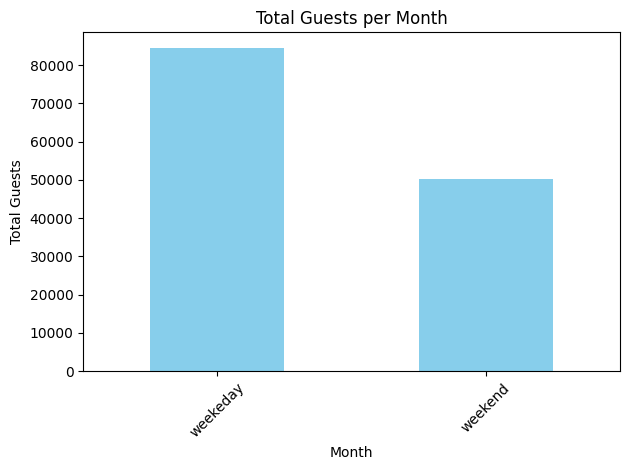

In [118]:
# Plot
pop.plot(kind='bar', color='skyblue')

plt.xlabel('Month')
plt.ylabel('Total Guests')
plt.title('Total Guests per Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [119]:
import datetime

# Use 2022 as per your question
start_date = datetime.date(2022, 5, 1)
end_date = datetime.date(2022, 7, 31)

# Including both start and end date
num_days = (end_date - start_date).days + 1
print("Number of days:", num_days)

# Initialize counters
weekdays = 0
weekends = 0

# Iterate through all days
current_date = start_date
while current_date <= end_date:
    if current_date.weekday() < 5:  # Mon-Fri are 0 to 4
        weekdays += 1
    else:  # Sat-Sun are 5, 6
        weekends += 1
    current_date += datetime.timedelta(days=1)

print("Total weekdays:", weekdays)
print("Total weekend days:", weekends)


Number of days: 92
Total weekdays: 65
Total weekend days: 27


In [120]:
filtered_df = df[df['booking_status'] != 'Cancelled']
total_guests = filtered_df['no_guests'].sum()

print("Total guests (excluding Cancelled):", total_guests)

Total guests (excluding Cancelled): 206185


In [121]:
# Calculate counts of booking status
status_counts = df['booking_status'].value_counts()

print(status_counts)


booking_status
Checked Out    94411
Cancelled      33420
No Show         6759
Name: count, dtype: int64


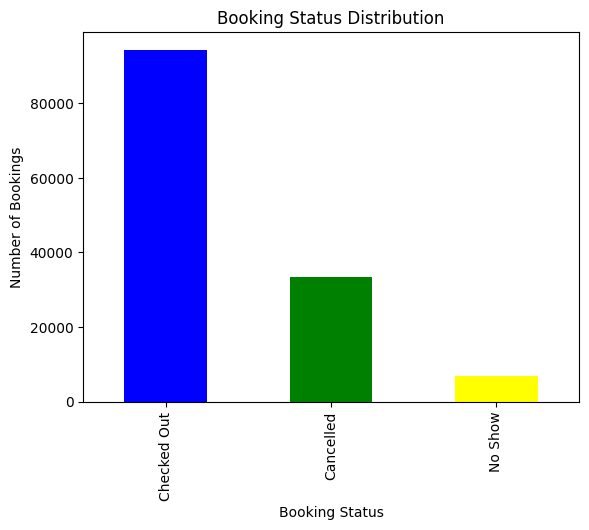

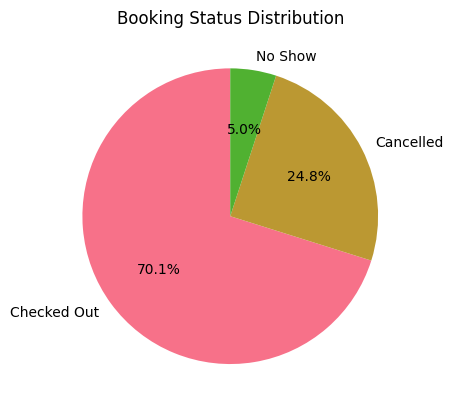

In [122]:
import matplotlib.pyplot as plt

status_counts = df['booking_status'].value_counts()

# Bar plot
status_counts.plot(kind='bar', color=['blue', 'green' , 'yellow'])
plt.title('Booking Status Distribution')
plt.ylabel('Number of Bookings')
plt.xlabel('Booking Status')
plt.show()

# OR Pie chart
status_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, color=['blue', 'green' , 'yellow'])
plt.ylabel('')
plt.title('Booking Status Distribution')
plt.show()


In [123]:
# Group by day_type and sum no_guests
weekday_ppl = filtered_df[ filtered_df['day_type'] == 'weekeday' ]['no_guests'].sum()
weekend_ppl = filtered_df[ filtered_df['day_type'] == 'weekend' ]['no_guests'].sum()

print(weekday_ppl)
print(weekend_ppl)

129083
77102


In [124]:
# avg_ppl_weekdays = (total no of ppl onn week day) / total no of week days 
avg_ppl_weekdays = int((weekday_ppl) / weekdays)
print(avg_ppl_weekdays)
# avg_ppl_weekends = (total no of ppl onn weekend days) / total no of week days
avg_ppl_weekends = int((weekend_ppl) / weekends)
print(avg_ppl_weekends)

1985
2855


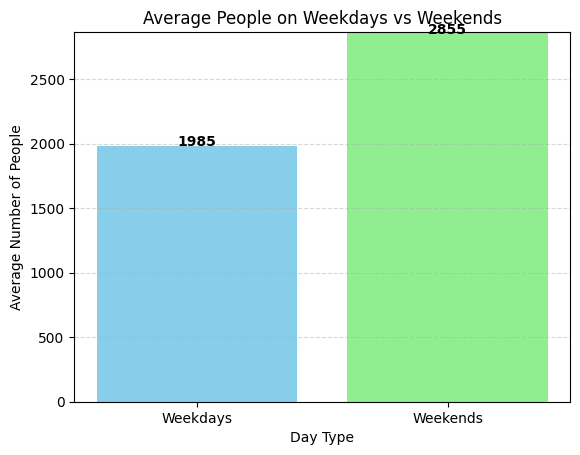

In [125]:
# Create lists for plotting
x_labels = ['Weekdays', 'Weekends']
y_values = [avg_ppl_weekdays, avg_ppl_weekends]

# Plot
plt.bar(x_labels, y_values, color=['skyblue', 'lightgreen'])

plt.title('Average People on Weekdays vs Weekends')
plt.xlabel('Day Type')
plt.ylabel('Average Number of People')
plt.ylim(0, max(y_values) + 10)  # Add some space on top
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Optionally add numbers on top of bars
for i, v in enumerate(y_values):
    plt.text(i, v + 0.5, str(int(v)), ha='center', fontweight='bold')

plt.show()

In [126]:
#Number of people in may-june-july:
# from datetime import datetime
df['month'] = df['mmm yy'].str.extract(r"^([A-Za-z]+)")[0]
df.head()

,property_name,category,city,room_class,no_guests,booking_platform,ratings_given,booking_status,mmm yy,week no,day_type,check_in_date,stay_duration,successful_bookings,capacity,revenue_generated,revenue_realized,occupancy_rate,Revenue_Leakage,month
0,Atliq Grands,Luxury,Delhi,Standard,3,direct online,1.0,Checked Out,May 22,W 19,weekend,2022-05-01,1,18,19,10010,10010,94.736842,0,May
1,Atliq Grands,Luxury,Delhi,Standard,2,others,NaN,Cancelled,May 22,W 19,weekend,2022-05-01,1,18,19,9100,3640,94.736842,5460,May
2,Atliq Grands,Luxury,Delhi,Standard,2,logtrip,5.0,Checked Out,May 22,W 19,weekend,2022-05-01,3,18,19,9100,9100,94.736842,0,May
3,Atliq Grands,Luxury,Delhi,Standard,2,others,NaN,Cancelled,May 22,W 19,weekend,2022-05-01,1,18,19,9100,3640,94.736842,5460,May
4,Atliq Grands,Luxury,Delhi,Standard,4,direct online,5.0,Checked Out,May 22,W 19,weekend,2022-05-01,1,18,19,10920,10920,94.736842,0,May


In [127]:
result = df.groupby('month')['no_guests'].sum()
print(result)

month
Jul    91723
Jun    89077
May    93334
Name: no_guests, dtype: int64


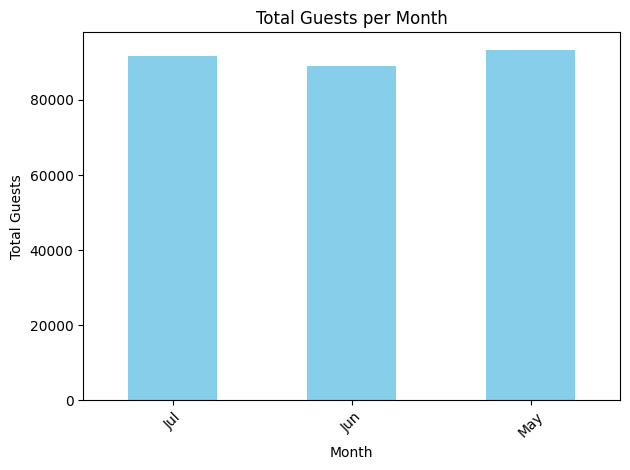

In [128]:
import matplotlib.pyplot as plt

# Plot
result.plot(kind='bar', color='skyblue')

plt.xlabel('Month')
plt.ylabel('Total Guests')
plt.title('Total Guests per Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [129]:
month_day_counts = df.groupby(['month', 'day_type']).size().reset_index(name='count')
print(month_day_counts)

  month  day_type  count
0   Jul  weekeday  26781
1   Jul   weekend  18244
2   Jun  weekeday  28692
3   Jun   weekend  14991
4   May  weekeday  28892
5   May   weekend  16990


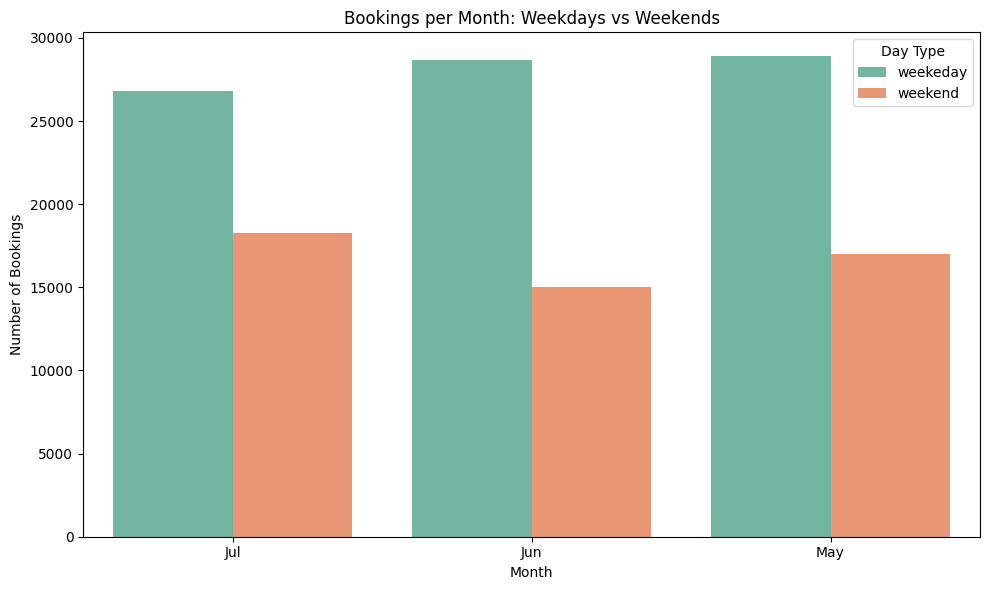

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=month_day_counts, x='month', y='count', hue='day_type', palette='Set2')

plt.title('Bookings per Month: Weekdays vs Weekends')
plt.xlabel('Month')
plt.ylabel('Number of Bookings')
plt.legend(title='Day Type')
plt.tight_layout()
plt.show()

In [131]:
# Group by city and sum number of guests
city_guests = df.groupby('city')['no_guests'].sum().reset_index()
print(city_guests)

        city  no_guests
0  Bangalore      65554
1      Delhi      47761
2  Hyderabad      72188
3     Mumbai      88631


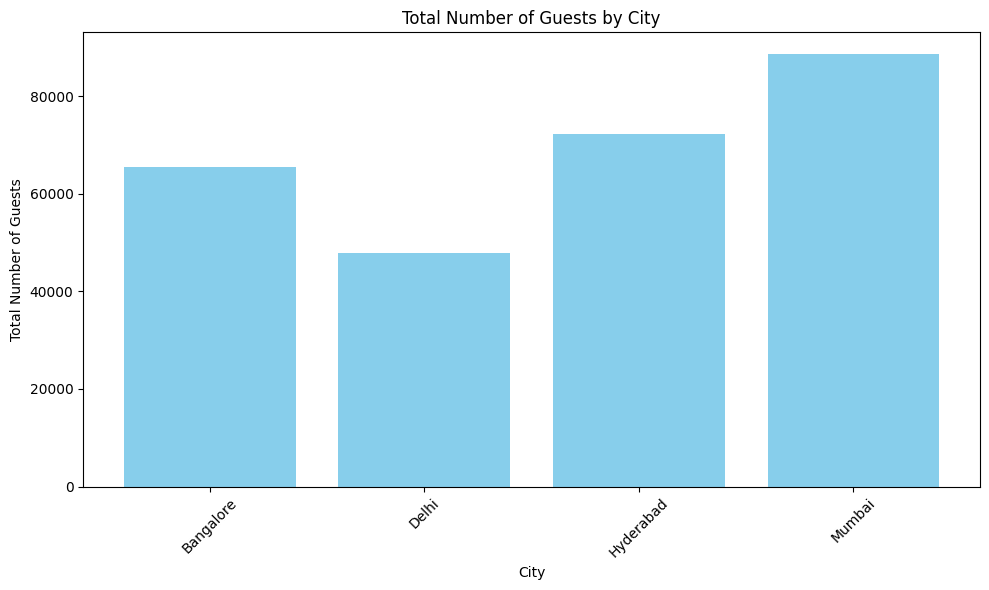

In [132]:
# Plot
plt.figure(figsize=(10, 6))
plt.bar(city_guests['city'], city_guests['no_guests'], color='skyblue')
plt.xlabel('City')
plt.ylabel('Total Number of Guests')
plt.title('Total Number of Guests by City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [133]:
grouped = df.groupby(['city', 'category'])['no_guests'].sum().reset_index()
print(grouped)

        city  category  no_guests
0  Bangalore  Business      18751
1  Bangalore    Luxury      46803
2      Delhi  Business      19727
3      Delhi    Luxury      28034
4  Hyderabad  Business      18984
5  Hyderabad    Luxury      53204
6     Mumbai  Business      27325
7     Mumbai    Luxury      61306


In [134]:
# Using value_counts
room_class_counts = df['room_class'].value_counts()

print(room_class_counts)


room_class
Elite           49505
Standard        38446
Premium         30566
Presidential    16073
Name: count, dtype: int64


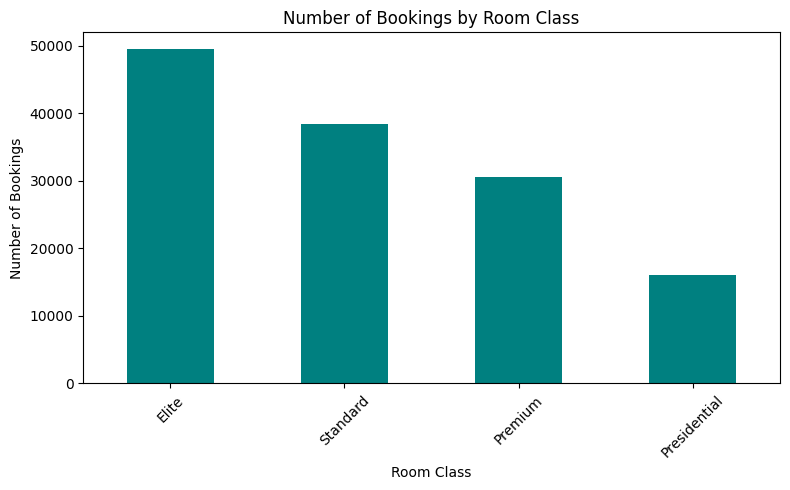

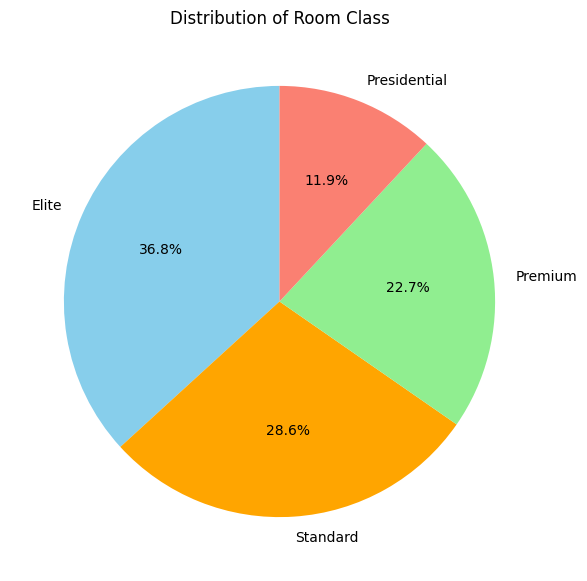

In [135]:
import matplotlib.pyplot as plt

room_class_counts = df['room_class'].value_counts()

plt.figure(figsize=(8, 5))
room_class_counts.plot(kind='bar', color='teal')
plt.xlabel('Room Class')
plt.ylabel('Number of Bookings')
plt.title('Number of Bookings by Room Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(7, 7))
room_class_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange', 'lightgreen', 'salmon'])
plt.ylabel('')
plt.title('Distribution of Room Class')
plt.show()


In [136]:
# Group by room class and calculate average revenue
avg_revenue = df.groupby('room_class')['revenue_generated'].mean().reset_index()

# Round for better readability
avg_revenue['revenue_generated'] = avg_revenue['revenue_generated'].round(2)

print(avg_revenue)


     room_class  revenue_generated
0         Elite           13310.70
1       Premium           17784.40
2  Presidential           27465.75
3      Standard            9456.00


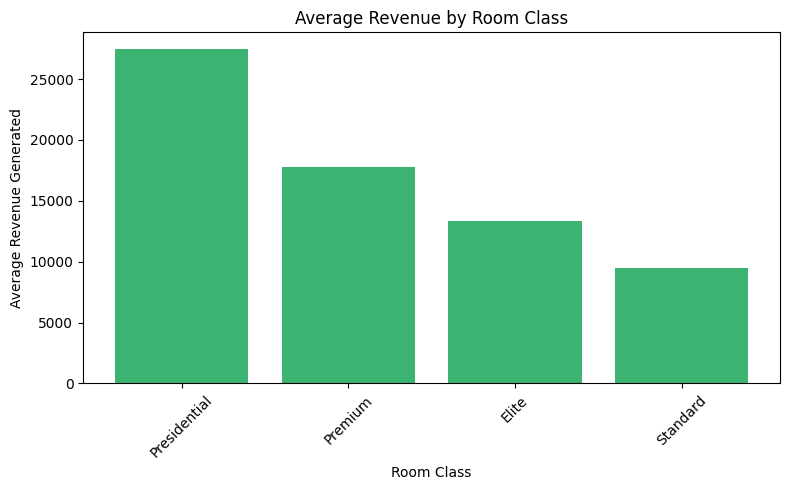

In [137]:
import matplotlib.pyplot as plt

# Sort for cleaner plot (optional)
avg_revenue = avg_revenue.sort_values(by='revenue_generated', ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(avg_revenue['room_class'], avg_revenue['revenue_generated'], color='mediumseagreen')
plt.xlabel('Room Class')
plt.ylabel('Average Revenue Generated')
plt.title('Average Revenue by Room Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


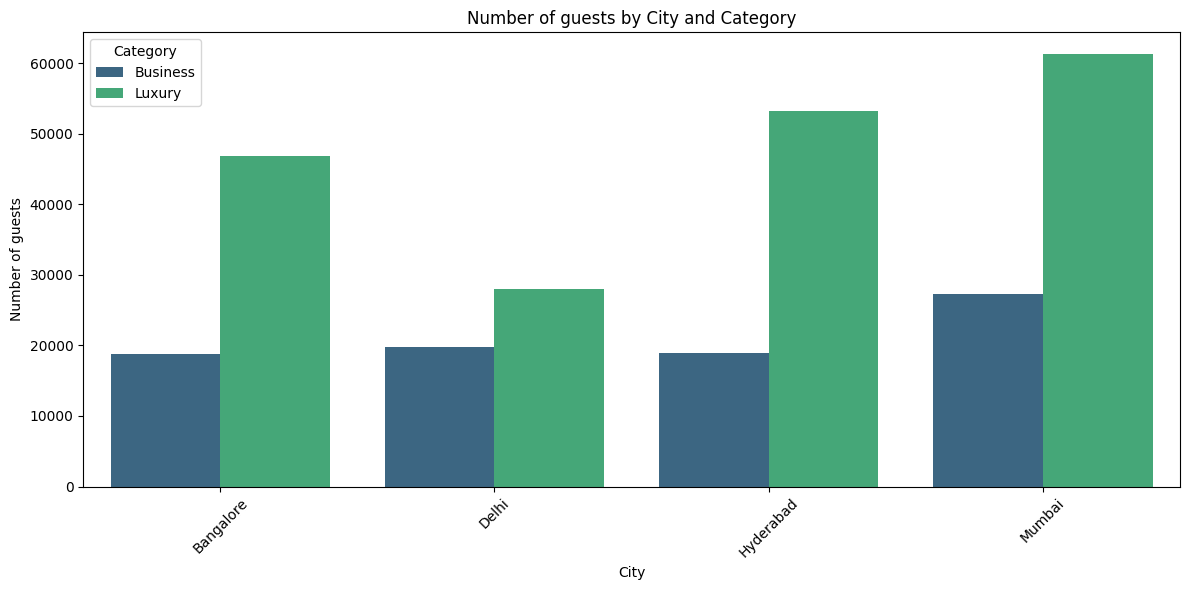

In [138]:
plt.figure(figsize=(12, 6))

sns.barplot(data=grouped, x='city', y='no_guests', hue='category', palette='viridis')

plt.title('Number of guests by City and Category')
plt.xlabel('City')
plt.ylabel('Number of guests')
plt.xticks(rotation=45)
plt.legend(title='Category')
plt.tight_layout()
plt.show()

In [139]:
df['property_name'].nunique()

7

In [140]:
# Removing the Nan values
filtered = df[df['ratings_given'].isin([1, 2, 3, 4, 5])]
rating_counts = filtered['ratings_given'].value_counts().sort_index()
print(rating_counts)

ratings_given
1.0     3537
2.0     6452
3.0    17561
4.0     9653
5.0    19480
Name: count, dtype: int64


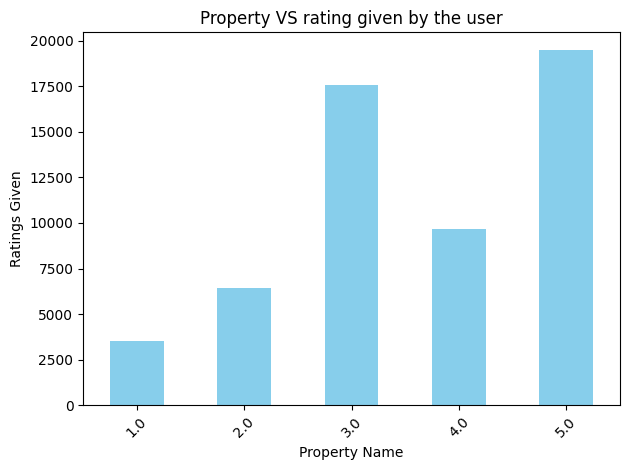

In [141]:
rating_counts.plot(kind='bar', color='skyblue')

plt.xlabel('Property Name')
plt.ylabel('Ratings Given')
plt.title('Property VS rating given by the user')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [142]:
# Counting Average rating of each hotel
avg_ratings = filtered.groupby('property_name')['ratings_given'].mean().reset_index()
avg_ratings['ratings_given'] = avg_ratings['ratings_given'].round(2)
avg_ratings = avg_ratings.set_index('property_name')


print(avg_ratings)

               ratings_given
property_name               
Atliq Bay               3.71
Atliq Blu               3.96
Atliq City              3.69
Atliq Exotica           3.62
Atliq Grands            3.10
Atliq Palace            3.75
Atliq Seasons           2.29


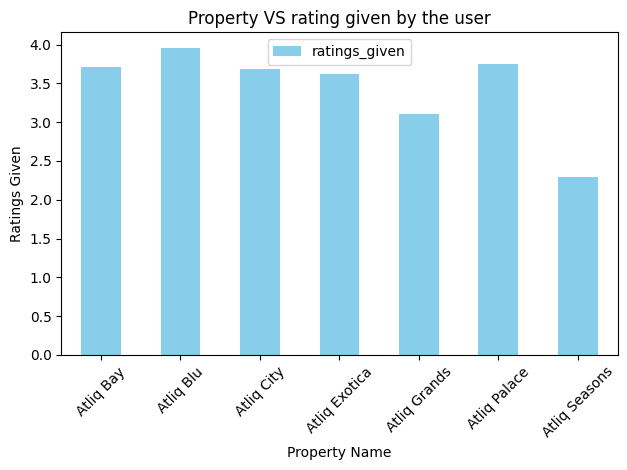

In [143]:
avg_ratings.plot(kind='bar', color='skyblue')

plt.xlabel('Property Name')
plt.ylabel('Ratings Given')
plt.title('Property VS rating given by the user')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [144]:
avg_ratings = filtered.groupby(['property_name', 'room_class'])['ratings_given'].mean().reset_index()

# Optional: round for nicer display
avg_ratings['ratings_given'] = avg_ratings['ratings_given'].round(2)

print(avg_ratings)


    property_name    room_class  ratings_given
0       Atliq Bay         Elite           3.55
1       Atliq Bay       Premium           3.70
2       Atliq Bay  Presidential           3.95
3       Atliq Bay      Standard           3.79
4       Atliq Blu         Elite           3.97
5       Atliq Blu       Premium           3.97
6       Atliq Blu  Presidential           4.04
7       Atliq Blu      Standard           3.92
8      Atliq City         Elite           3.71
9      Atliq City       Premium           3.68
10     Atliq City  Presidential           3.84
11     Atliq City      Standard           3.62
12  Atliq Exotica         Elite           3.64
13  Atliq Exotica       Premium           3.61
14  Atliq Exotica  Presidential           3.65
15  Atliq Exotica      Standard           3.59
16   Atliq Grands         Elite           3.14
17   Atliq Grands       Premium           3.07
18   Atliq Grands  Presidential           3.03
19   Atliq Grands      Standard           3.10
20   Atliq Pa

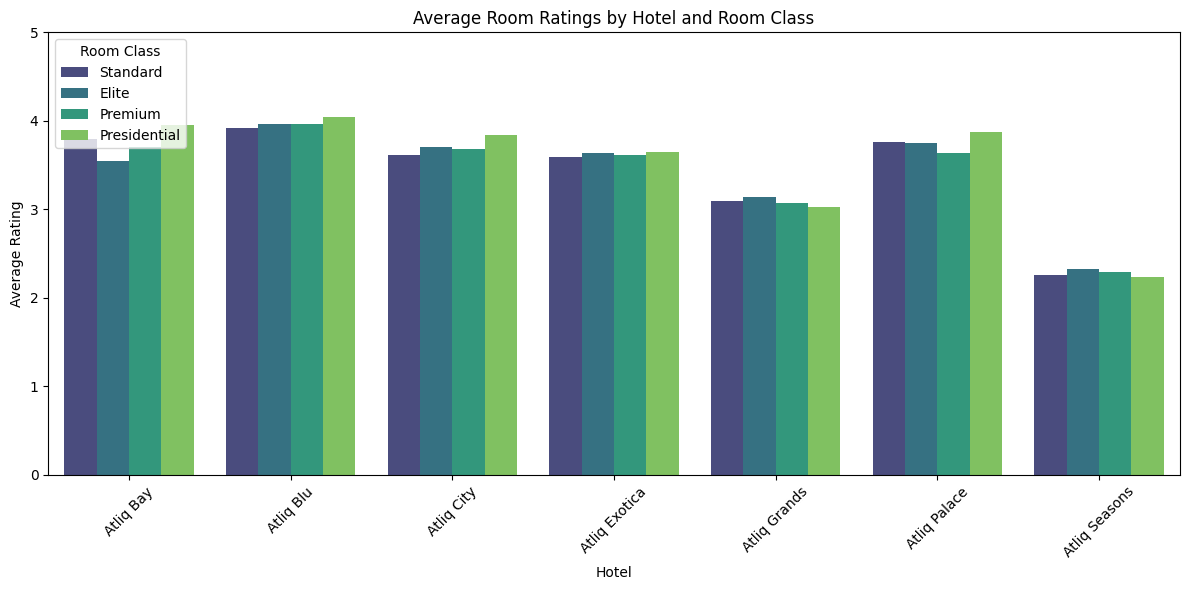

In [145]:
# Define the order
room_order = ['Standard', 'Elite', 'Premium', 'Presidential']
# Convert to categorical with order
avg_ratings['room_class'] = pd.Categorical(avg_ratings['room_class'], categories=room_order, ordered=True)

avg_ratings = avg_ratings.sort_values(['property_name', 'room_class'])


plt.figure(figsize=(12, 6))

sns.barplot(data=avg_ratings, x='property_name', y='ratings_given', hue='room_class', palette='viridis')

plt.xlabel('Hotel')
plt.ylabel('Average Rating')
plt.title('Average Room Ratings by Hotel and Room Class')
plt.ylim(0, 5)
plt.xticks(rotation=45)
plt.legend(title='Room Class', loc='upper left')
plt.tight_layout()
plt.show()

In [146]:
# Booking plateform 
platform_counts = df['booking_platform'].value_counts()
platform_counts

booking_platform
others            55066
makeyourtrip      26898
logtrip           14756
direct online     13379
tripster           9630
journey            8106
direct offline     6755
Name: count, dtype: int64

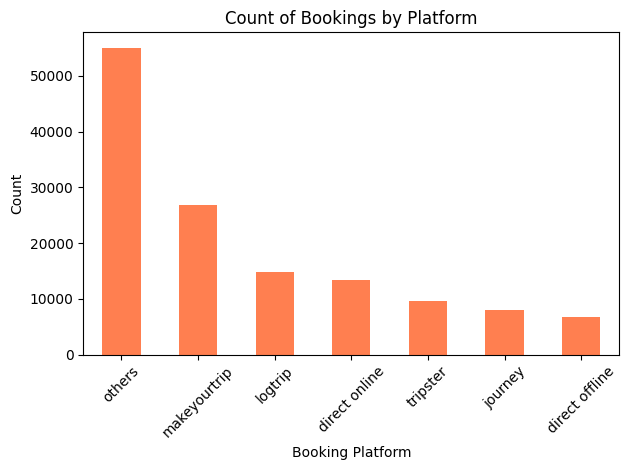

In [147]:
import matplotlib.pyplot as plt

platform_counts.plot(kind='bar', color='coral')
plt.xlabel('Booking Platform')
plt.ylabel('Count')
plt.title('Count of Bookings by Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [148]:
# Cancellation data:
cancel_counts = df.groupby(['booking_platform', 'booking_status']).size().reset_index(name='count')
print(cancel_counts)

   booking_platform booking_status  count
0    direct offline      Cancelled   1654
1    direct offline    Checked Out   4742
2    direct offline        No Show    359
3     direct online      Cancelled   3344
4     direct online    Checked Out   9401
5     direct online        No Show    634
6           journey      Cancelled   2009
7           journey    Checked Out   5716
8           journey        No Show    381
9           logtrip      Cancelled   3586
10          logtrip    Checked Out  10416
11          logtrip        No Show    754
12     makeyourtrip      Cancelled   6722
13     makeyourtrip    Checked Out  18825
14     makeyourtrip        No Show   1351
15           others      Cancelled  13698
16           others    Checked Out  38586
17           others        No Show   2782
18         tripster      Cancelled   2407
19         tripster    Checked Out   6725
20         tripster        No Show    498


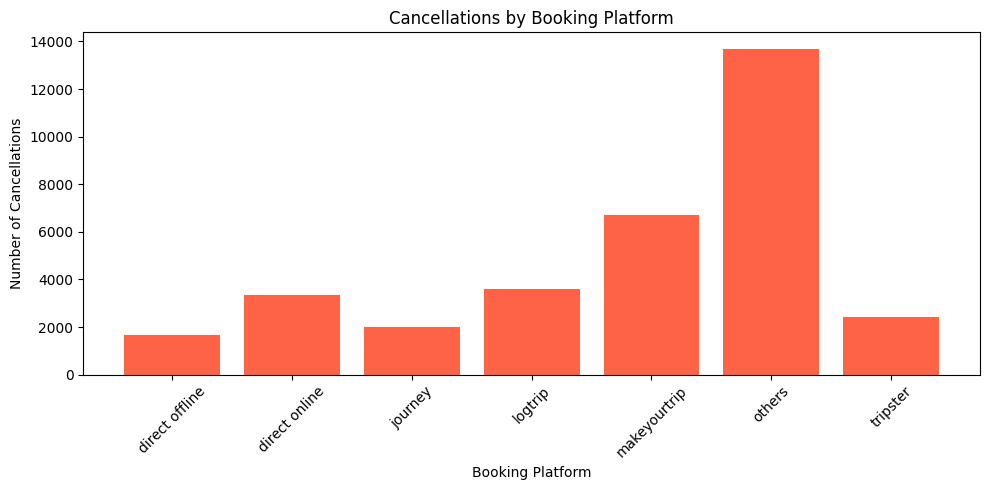

In [149]:

cancel_only = cancel_counts[cancel_counts['booking_status'] == 'Cancelled']

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(cancel_only['booking_platform'], cancel_only['count'], color='tomato')
plt.xlabel('Booking Platform')
plt.ylabel('Number of Cancellations')
plt.title('Cancellations by Booking Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Weekly aggregated data prepared.
Data shape: (12, 18)

Training models for revenue_realized...

revenue_realized Forecasting Accuracy:
Linear Regression MAE: 0.00
Random Forest MAE: 9790236.25

Training models for occupancy_rate...

occupancy_rate Forecasting Accuracy:
Linear Regression MAE: 2.09
Random Forest MAE: 4.58

Training models for RevPAR...

RevPAR Forecasting Accuracy:
Linear Regression MAE: 1.55
Random Forest MAE: 1.46

Training models for ADR...

ADR Forecasting Accuracy:
Linear Regression MAE: 28.61
Random Forest MAE: 62.69

=== WEEK-ON-WEEK (WoW) ANALYSIS ===
Revenue_WoW: -0.97% average growth
Occupancy_WoW: -1.20% average growth
RevPAR_WoW: 0.10% average growth
ADR_WoW: 2.09% average growth


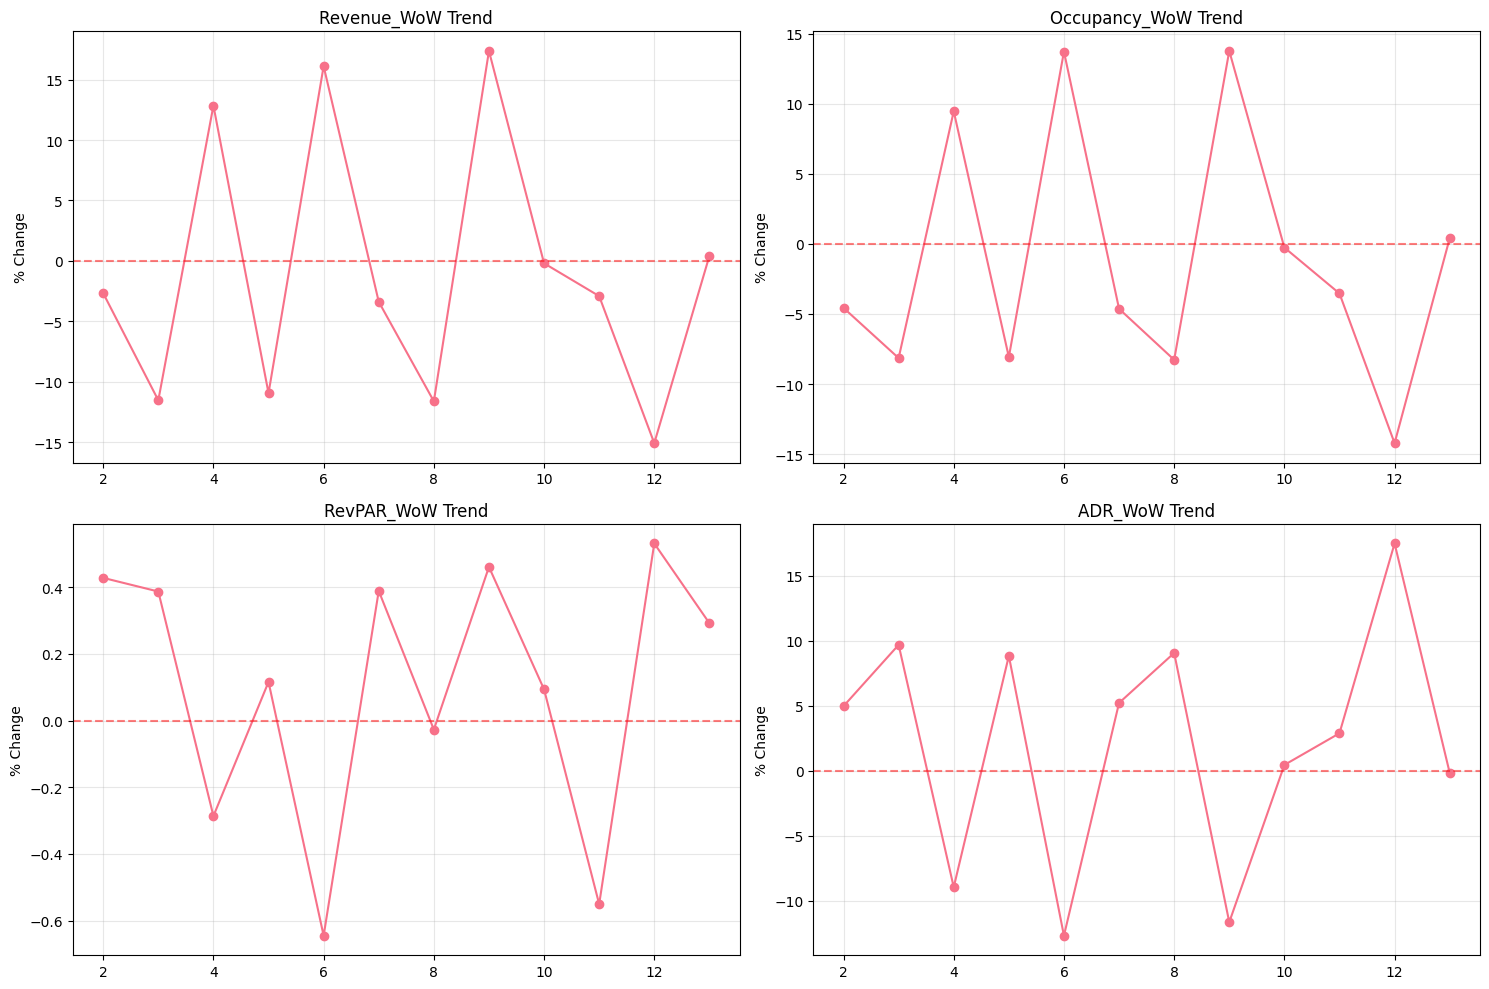

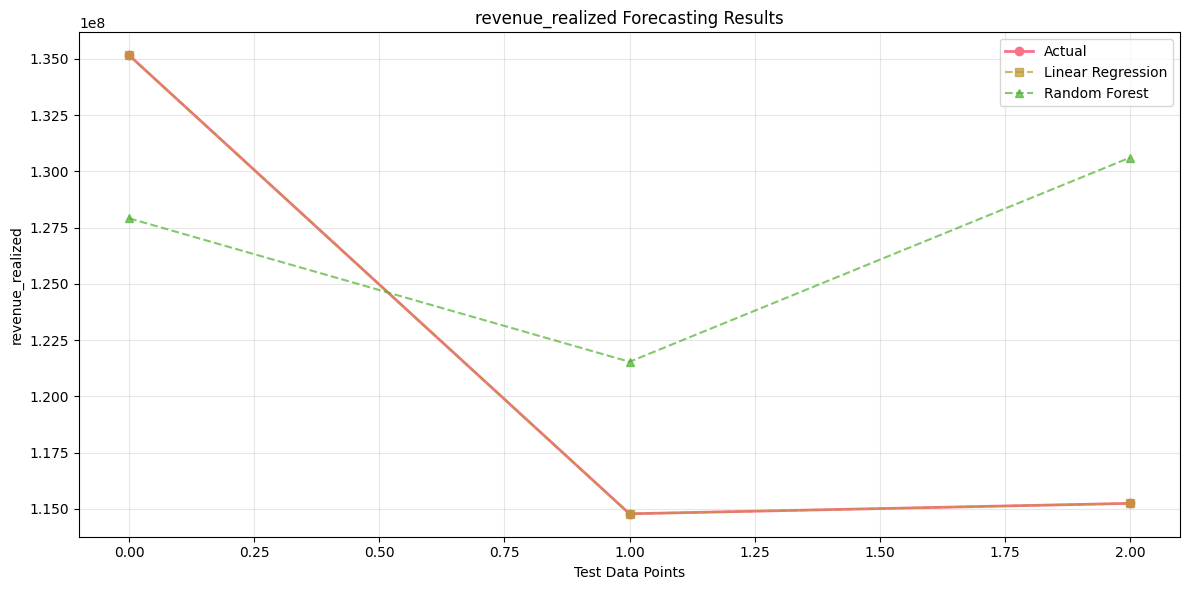

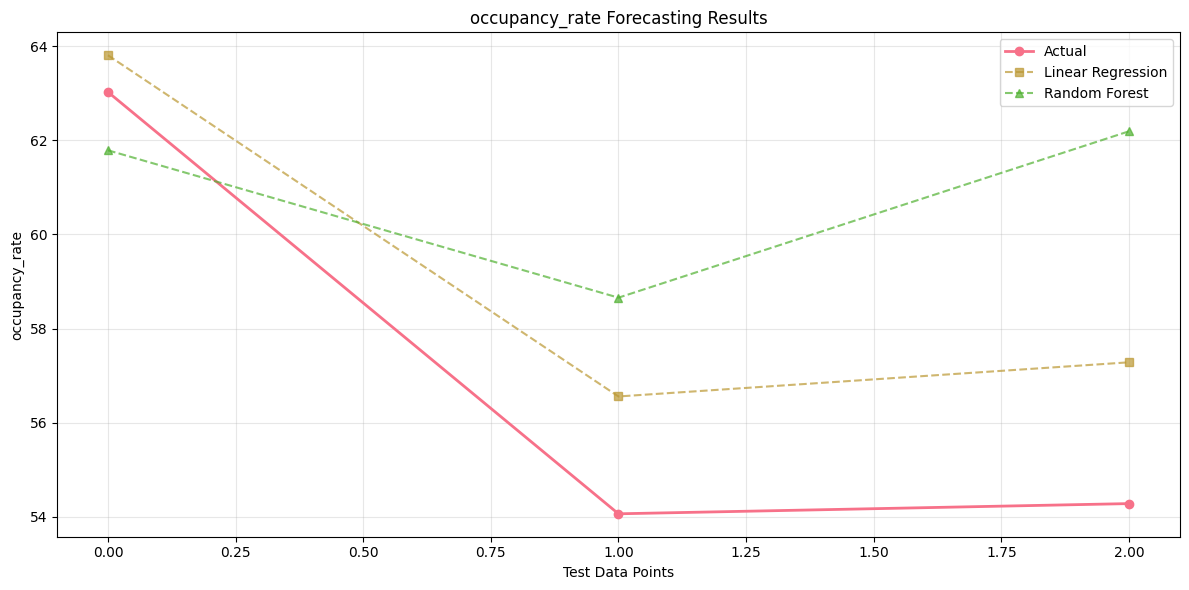

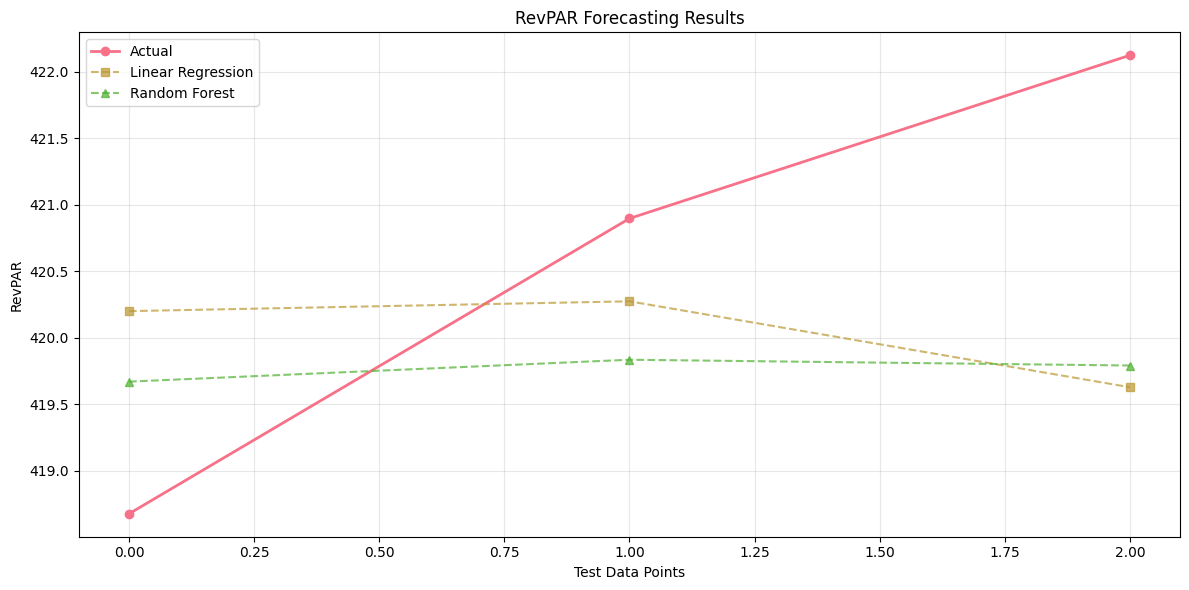

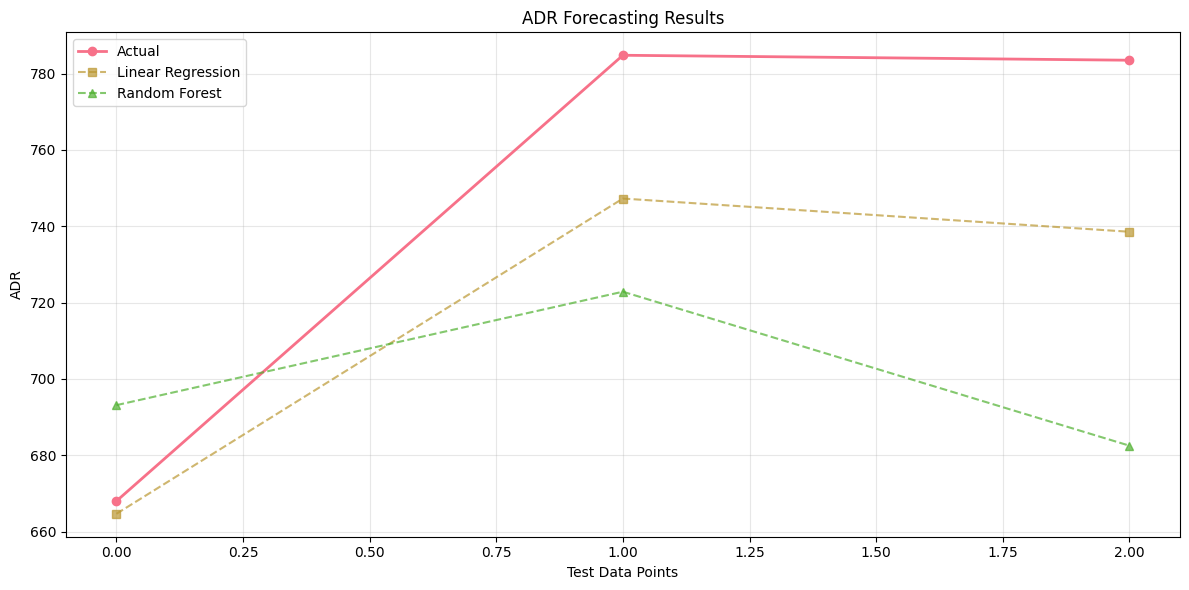


=== PREDICTIONS FOR NEXT 1 PERIODS ===
Next period revenue_realized: 130609708.97
Next period occupancy_rate: 62.19
Next period RevPAR: 419.79
Next period ADR: 682.51

=== FORECASTING COMPLETE ===


In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# 1. DATA PREPARATION FOR FORECASTING
def prepare_forecast_data(df):
    df['week_year'] = df['check_in_date'].dt.isocalendar().week.astype(str) + '_' + df['check_in_date'].dt.year.astype(str)
    
    weekly_data = df.groupby('week_year').agg({
        'revenue_realized': 'sum',
        'revenue_generated': 'sum', 
        'occupancy_rate': 'mean',
        'successful_bookings': 'sum',
        'capacity': 'sum',
        'stay_duration': 'mean',
        'no_guests': 'sum'
    }).reset_index()
    
    # KPIs
    weekly_data['RevPAR'] = weekly_data['revenue_realized'] / weekly_data['capacity']
    weekly_data['ADR'] = weekly_data['revenue_realized'] / weekly_data['successful_bookings']
    weekly_data['Revenue_WoW'] = weekly_data['revenue_realized'].pct_change() * 100
    weekly_data['Occupancy_WoW'] = weekly_data['occupancy_rate'].pct_change() * 100
    weekly_data['RevPAR_WoW'] = weekly_data['RevPAR'].pct_change() * 100
    weekly_data['ADR_WoW'] = weekly_data['ADR'].pct_change() * 100

    # Time features
    weekly_data['week_num'] = np.arange(len(weekly_data))
    weekly_data['lag1_revenue'] = weekly_data['revenue_realized'].shift(1)
    weekly_data['lag2_revenue'] = weekly_data['revenue_realized'].shift(2)
    weekly_data['moving_avg_3'] = weekly_data['revenue_realized'].rolling(3).mean()
    
    return weekly_data.dropna()

# 2. FORECASTING MODELS
class HospitalityForecaster:
    def __init__(self):
        self.models = {}
        self.predictions = {}
        
    def train_models(self, data, target_col, features):
        X = data[features]
        y = data[target_col]
        
        split_idx = int(0.8 * len(data))
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
        
        # Linear Regression
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        lr_pred = lr_model.predict(X_test)
        
        # Random Forest
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        rf_pred = rf_model.predict(X_test)
        
        self.models[target_col] = {'lr': lr_model, 'rf': rf_model}
        self.predictions[target_col] = {
            'actual': y_test.values,
            'lr_pred': lr_pred,
            'rf_pred': rf_pred,
            'dates': data.iloc[split_idx:]['week_year'].values
        }
        
        # Print accuracy
        lr_mae = mean_absolute_error(y_test, lr_pred)
        rf_mae = mean_absolute_error(y_test, rf_pred)
        
        print(f"\n{target_col} Forecasting Accuracy:")
        print(f"Linear Regression MAE: {lr_mae:.2f}")
        print(f"Random Forest MAE: {rf_mae:.2f}")

# 3. MAIN FORECASTING PIPELINE
def run_forecasting_pipeline(df):
    weekly_data = prepare_forecast_data(df)
    print("Weekly aggregated data prepared.")
    print(f"Data shape: {weekly_data.shape}")
    
    forecaster = HospitalityForecaster()
    
    features = ['week_num', 'lag1_revenue', 'lag2_revenue', 'moving_avg_3']
    kpis = ['revenue_realized', 'occupancy_rate', 'RevPAR', 'ADR']
    
    for kpi in kpis:
        if kpi in weekly_data.columns:
            print(f"\nTraining models for {kpi}...")
            forecaster.train_models(weekly_data, kpi, features)
    
    return forecaster, weekly_data

# 4. VISUALIZATION FUNCTION
def plot_forecasts(forecaster, kpi):
    if kpi not in forecaster.predictions:
        print(f"No predictions available for {kpi}")
        return
    
    data = forecaster.predictions[kpi]
    
    plt.figure(figsize=(12, 6))
    x_range = range(len(data['actual']))
    plt.plot(x_range, data['actual'], 'o-', label='Actual', linewidth=2)
    plt.plot(x_range, data['lr_pred'], 's--', label='Linear Regression', alpha=0.7)
    plt.plot(x_range, data['rf_pred'], '^--', label='Random Forest', alpha=0.7)
    
    plt.title(f'{kpi} Forecasting Results')
    plt.xlabel('Test Data Points')
    plt.ylabel(kpi)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 5. WOW ANALYSIS
def wow_analysis(weekly_data):
    print("\n=== WEEK-ON-WEEK (WoW) ANALYSIS ===")
    wow_metrics = ['Revenue_WoW', 'Occupancy_WoW', 'RevPAR_WoW', 'ADR_WoW']
    
    for metric in wow_metrics:
        if metric in weekly_data.columns:
            avg_growth = weekly_data[metric].mean()
            print(f"{metric}: {avg_growth:.2f}% average growth")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, metric in enumerate(wow_metrics):
        if metric in weekly_data.columns:
            axes[i].plot(weekly_data[metric], marker='o')
            axes[i].set_title(f'{metric} Trend')
            axes[i].set_ylabel('% Change')
            axes[i].grid(True, alpha=0.3)
            axes[i].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# 6. QUICK PREDICTIONS FOR NEXT PERIODS
def predict_next_periods(forecaster, weekly_data, periods=1):
    print(f"\n=== PREDICTIONS FOR NEXT {periods} PERIODS ===")
    
    last_row = weekly_data.iloc[-1:].copy()
    
    for kpi in ['revenue_realized', 'occupancy_rate', 'RevPAR', 'ADR']:
        if kpi in forecaster.models:
            model = forecaster.models[kpi]['rf']
            
            features = ['week_num', 'lag1_revenue', 'lag2_revenue', 'moving_avg_3']
            X_pred = last_row[features]
            prediction = model.predict(X_pred)[0]
            print(f"Next period {kpi}: {prediction:.2f}")

# 7. RUN EVERYTHING
if __name__ == "__main__":
    # Example: df = pd.read_csv("your_data.csv", parse_dates=['check_in_date'])
    # df['check_in_date'] = pd.to_datetime(df['check_in_date'])
    
    forecaster, weekly_data = run_forecasting_pipeline(df)
    wow_analysis(weekly_data)
    
    for kpi in ['revenue_realized', 'occupancy_rate', 'RevPAR', 'ADR']:
        plot_forecasts(forecaster, kpi)
    
    predict_next_periods(forecaster, weekly_data)
    print("\n=== FORECASTING COMPLETE ===")


HOSPITALITY REVENUE LEAKAGE & PROFITABILITY ANALYSIS

1. BOOKING TRENDS ANALYSIS
----------------------------------------
Booking Trends by Day Type:
          no_guests  revenue_generated  revenue_realized  Revenue_Leakage  \
day_type                                                                    
weekeday     172096         1259067580        1069703782        189363798   
weekend      102038          748478635         639067447        109411188   

          occupancy_rate  
day_type                  
weekeday           53.24  
weekend            76.06  


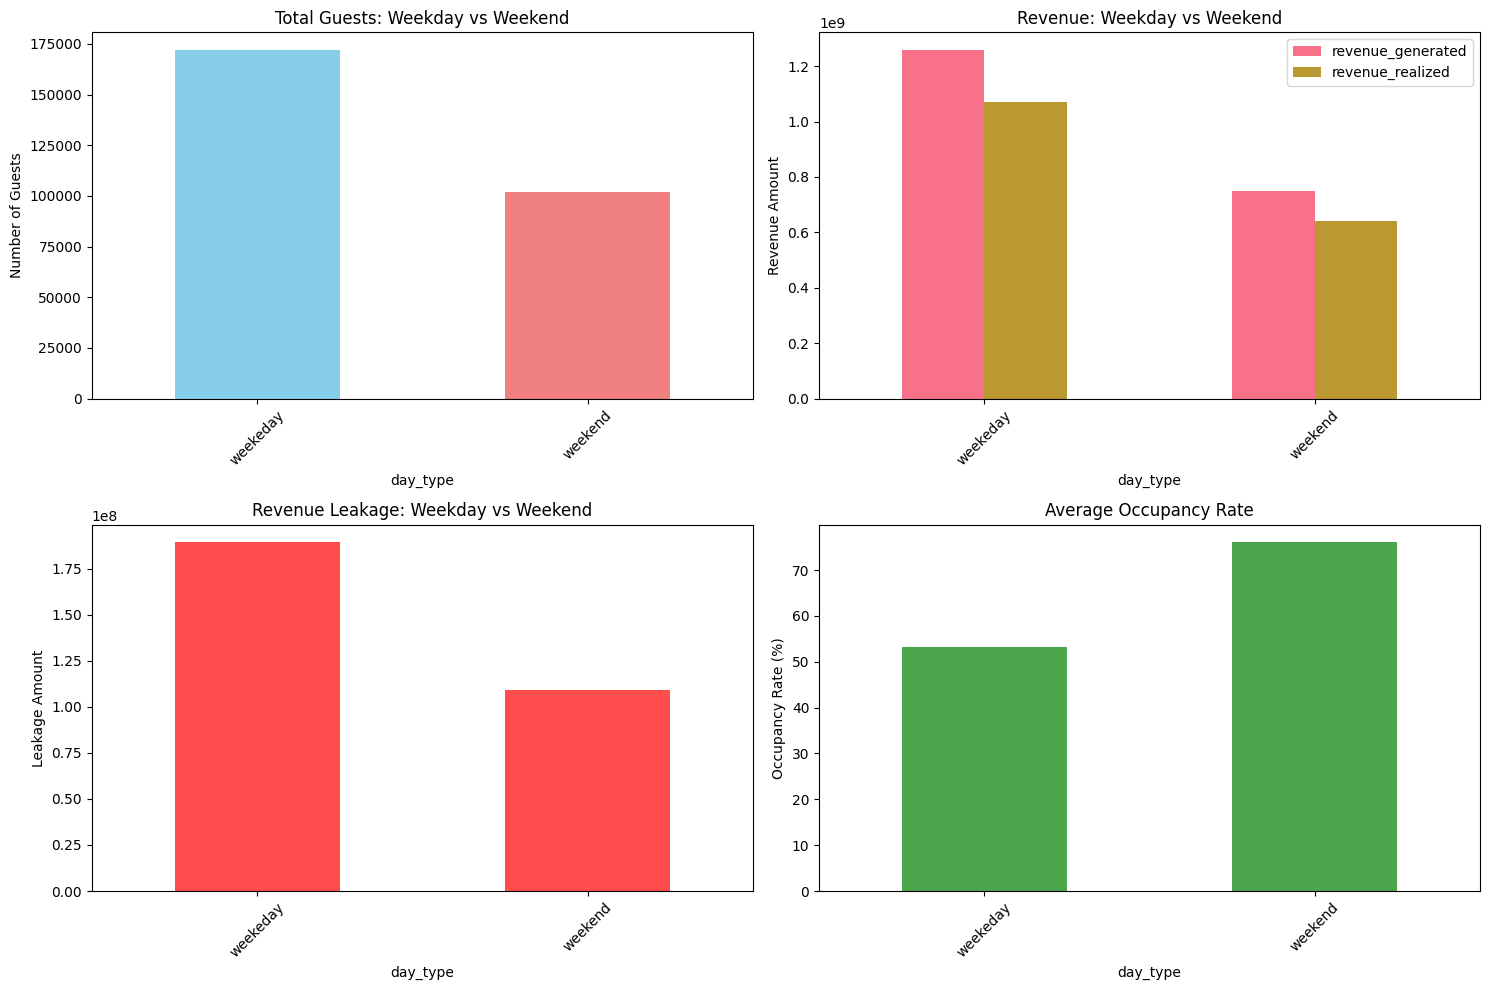


Booking Analysis by Room Types:
              no_guests  revenue_generated  revenue_realized  Revenue_Leakage  \
room_class                                                                      
Elite             97469          658946160         560271204         98674956   
Premium           66636          543597840         462166344         81431496   
Presidential      33841          441457020         376752786         64704234   
Standard          76188          363545195         309580895         53964300   

              occupancy_rate  
room_class                    
Elite                  61.40  
Premium                61.48  
Presidential           63.42  
Standard               61.74  


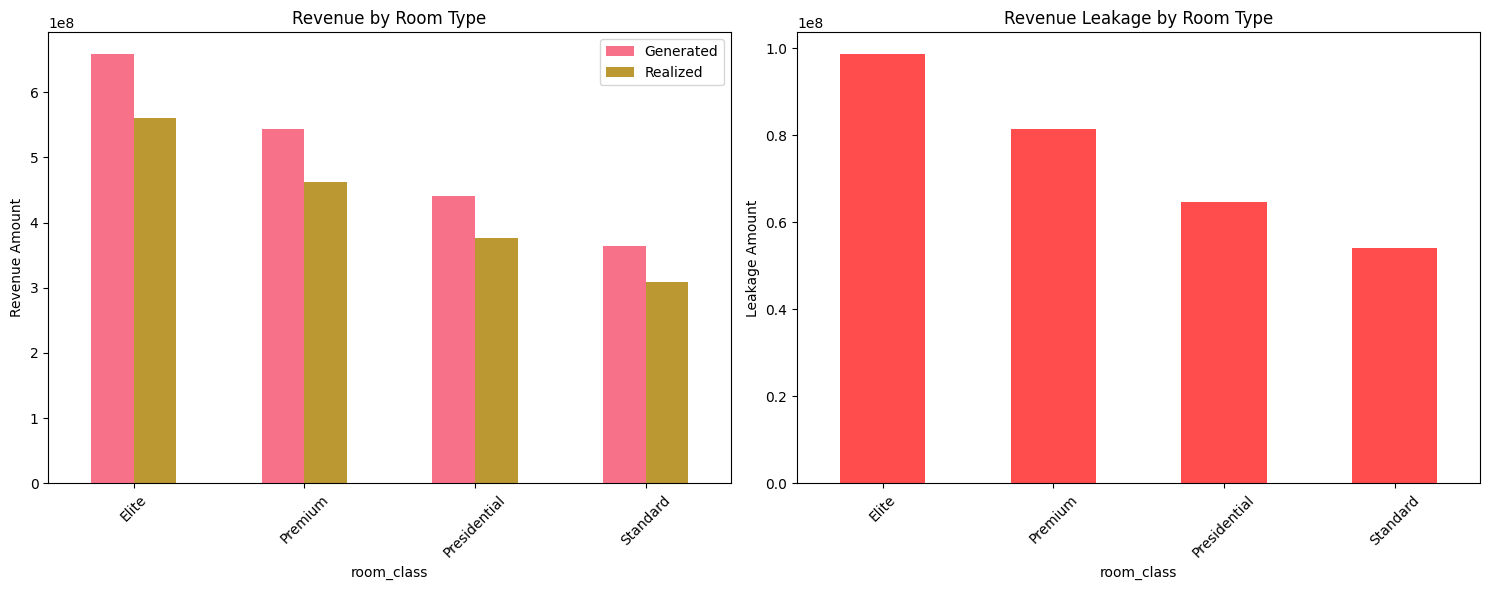


2. SEASONAL OCCUPANCY VS REVENUE CORRELATION
--------------------------------------------------
Monthly Seasonal Analysis:
        occupancy_rate  revenue_generated  revenue_realized  Revenue_Leakage  \
mmm yy                                                                         
Jul 22           61.44          671724125         572908208         98815917   
Jun 22           61.41          651939535         553932355         98007180   
May 22           62.39          683882555         581930666        101951889   

        no_guests  
mmm yy             
Jul 22      91723  
Jun 22      89077  
May 22      93334  

Correlation between Occupancy Rate and Revenue Realized: 0.019


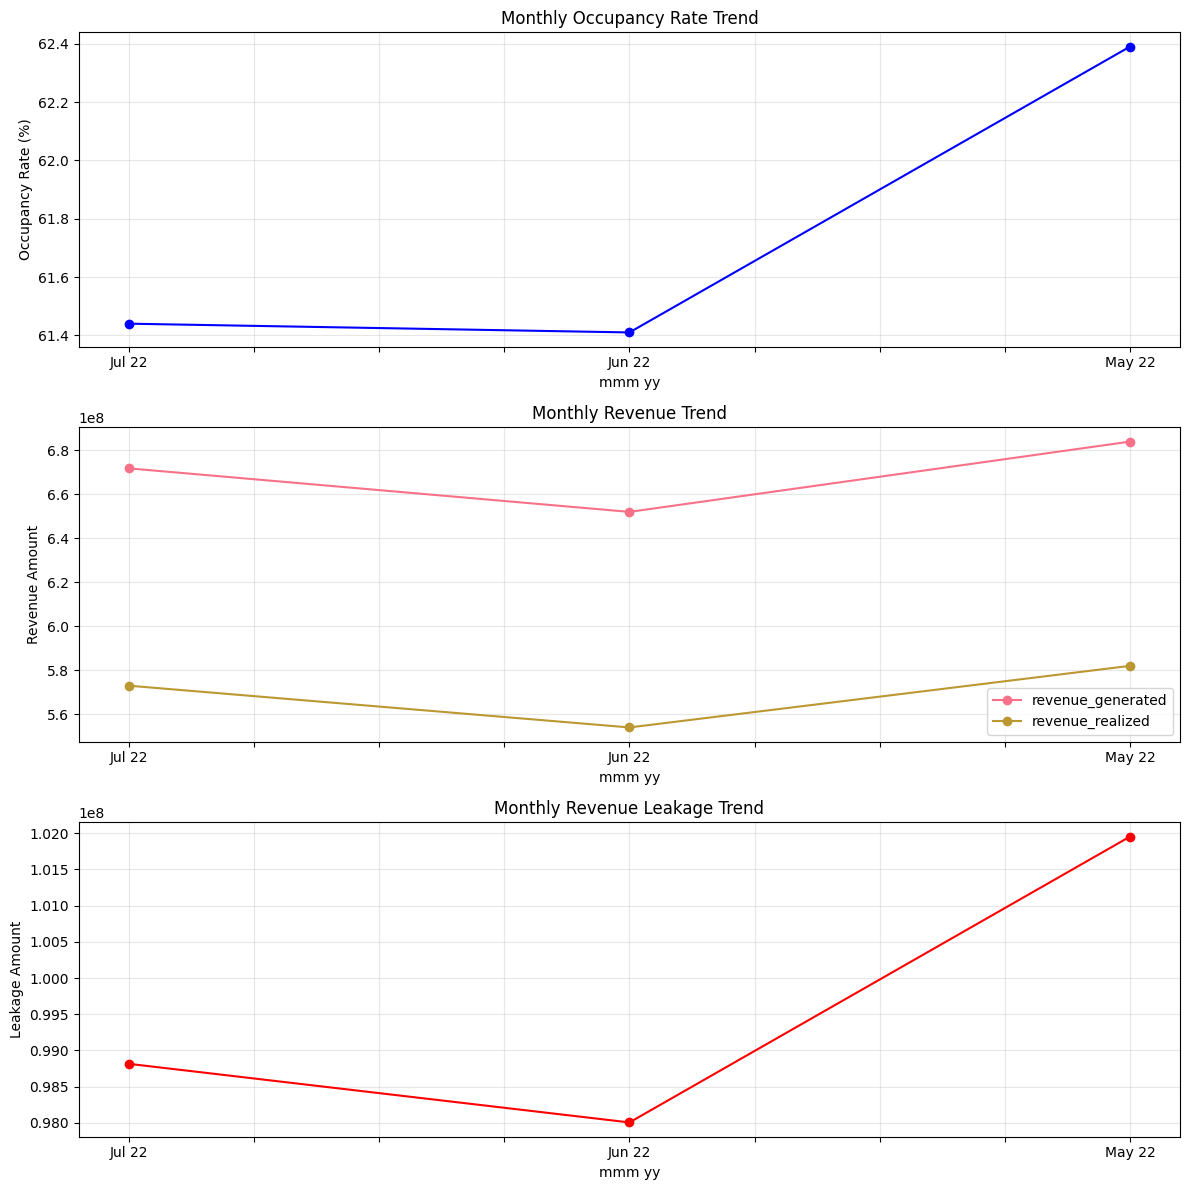


3. BOOKING PLATFORM ANALYSIS
-----------------------------------
Platform Performance:
                  no_guests  revenue_generated  revenue_realized  \
booking_platform                                                   
direct offline        13731          101359255          86404333   
direct online         27307          198770030         169026467   
journey               16529          120654715         102531334   
logtrip               29883          219478955         187554488   
makeyourtrip          54780          401502130         340834504   
others               112019          821066620         699353302   
tripster              19885          144714510         123066801   

                  Revenue_Leakage  ratings_given  
booking_platform                                  
direct offline           14954922           3.62  
direct online            29743563           3.61  
journey                  18123381           3.63  
logtrip                  31924467           

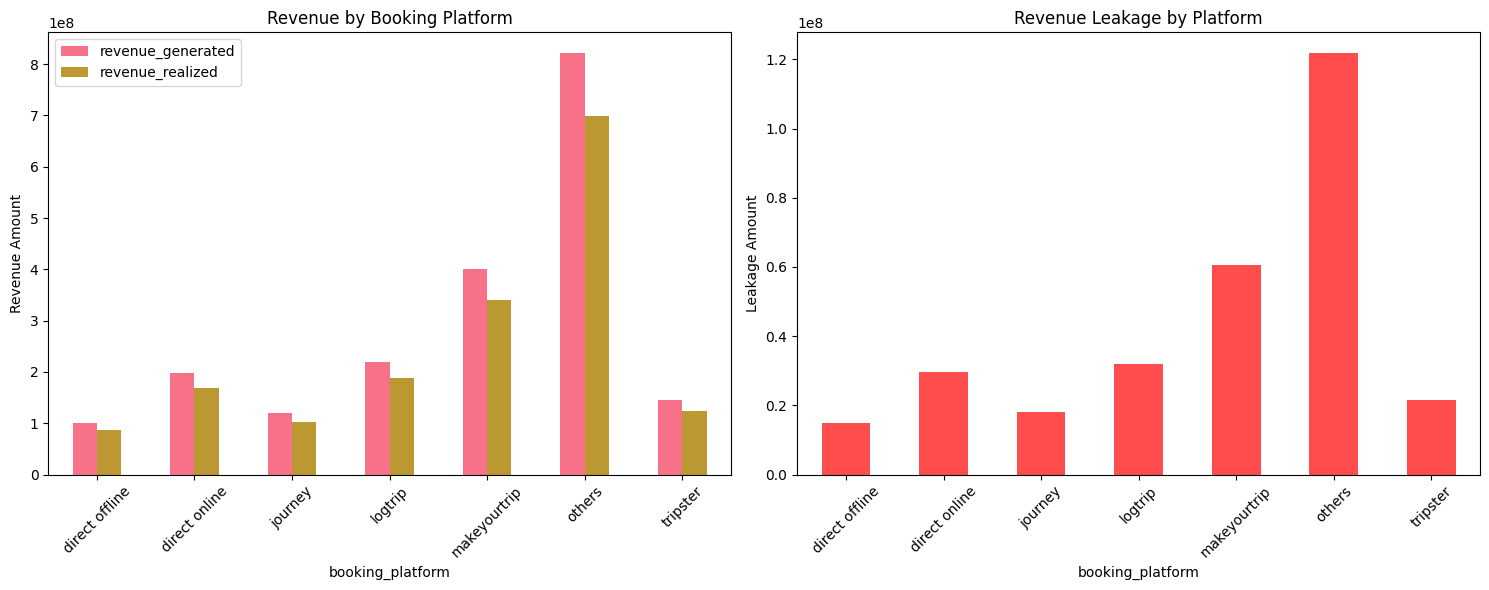


4. CUSTOMER SEGMENTATION BASED ON SPENDING BEHAVIOR
-------------------------------------------------------
Customer Segmentation Analysis:
                  no_guests  revenue_generated  revenue_realized  \
spending_segment                                                   
Low Spender           91993          402667880         233198018   
Medium Spender        79433          468294585         389756421   
High Spender          62342          517366130         483709430   
Premium Spender       40366          619217620         602107360   

                  Revenue_Leakage  stay_duration  ratings_given  
spending_segment                                                 
Low Spender             169469862           2.48           3.63  
Medium Spender           78538164           2.48           3.61  
High Spender             33656700           2.38           3.62  
Premium Spender          17110260           2.14           3.63  


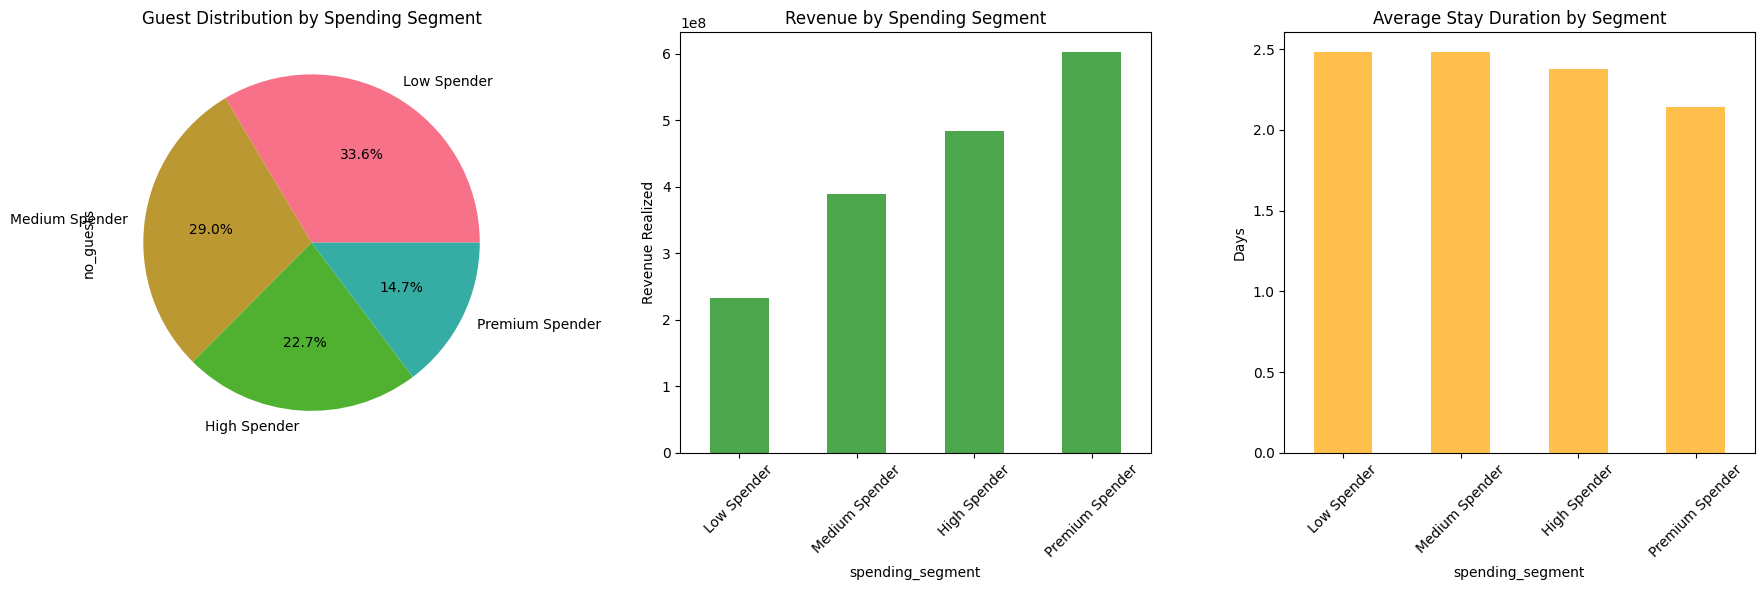


ROOT CAUSE ANALYSIS

1. UNDERPERFORMING ROOMS/SERVICES ANALYSIS
---------------------------------------------
Occupancy threshold for underperformance: 48.00%

Underperforming Rooms (Bottom 20% Occupancy):
                            occupancy_rate  revenue_realized  Revenue_Leakage  \
property_name room_class                                                        
Atliq Seasons Elite                  46.73          22094118          3813372   
              Premium                47.60          17970360          3353760   
              Presidential           46.26          19767600          3294600   
              Standard               46.01           6293417          1078038   

                            ratings_given  
property_name room_class                   
Atliq Seasons Elite                  2.33  
              Premium                2.29  
              Presidential           2.24  
              Standard               2.26  

Revenue Leakage by Property:
            

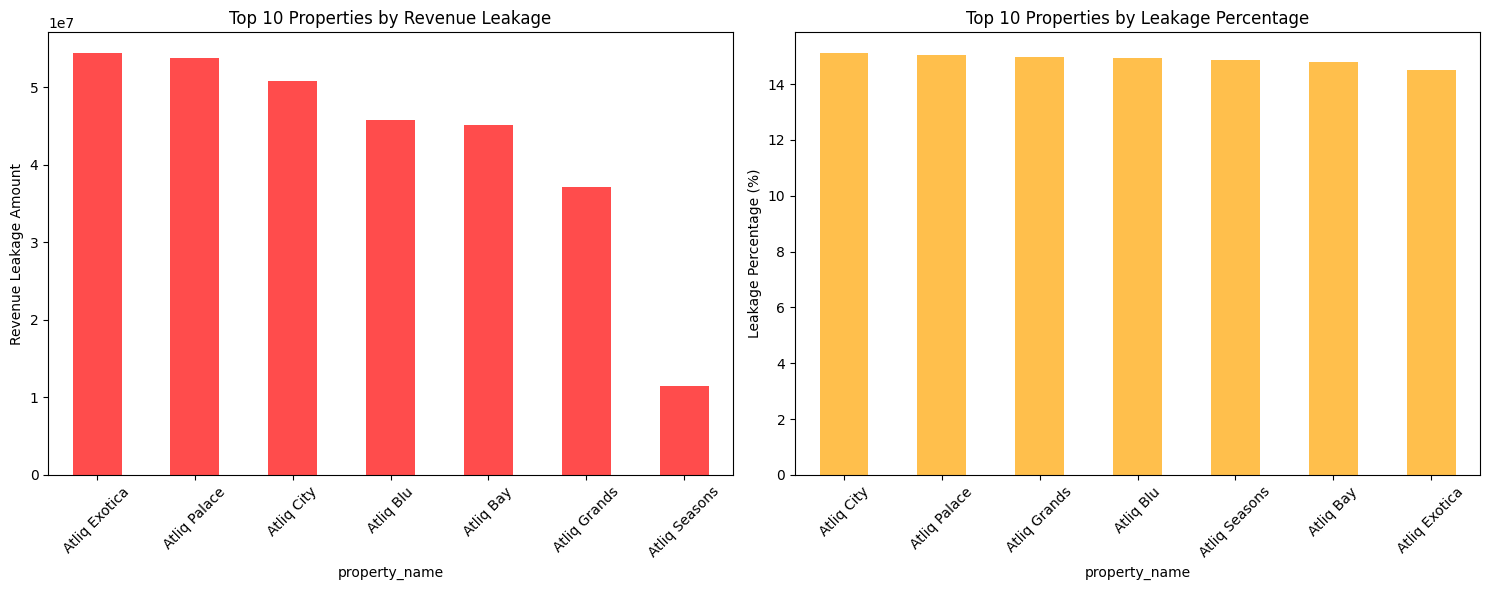


2. BOOKING STATUS & CANCELLATION ANALYSIS
---------------------------------------------
Booking Status Analysis:
                no_guests  revenue_generated  revenue_realized  \
booking_status                                                   
Cancelled           67949          497958310         199183324   
Checked Out        192449         1409113965        1409113965   
No Show             13736          100473940         100473940   

                Revenue_Leakage  
booking_status                   
Cancelled             298774986  
Checked Out                   0  
No Show                       0  

Cancellation Rate by Room Class (%):
booking_status  Cancelled  Checked Out  No Show
room_class                                     
Elite               24.96        70.00     5.04
Premium             24.88        70.17     4.95
Presidential        24.44        70.58     4.98
Standard            24.79        70.14     5.07

Cancellation Rate by Platform (%):
booking_status    Cance

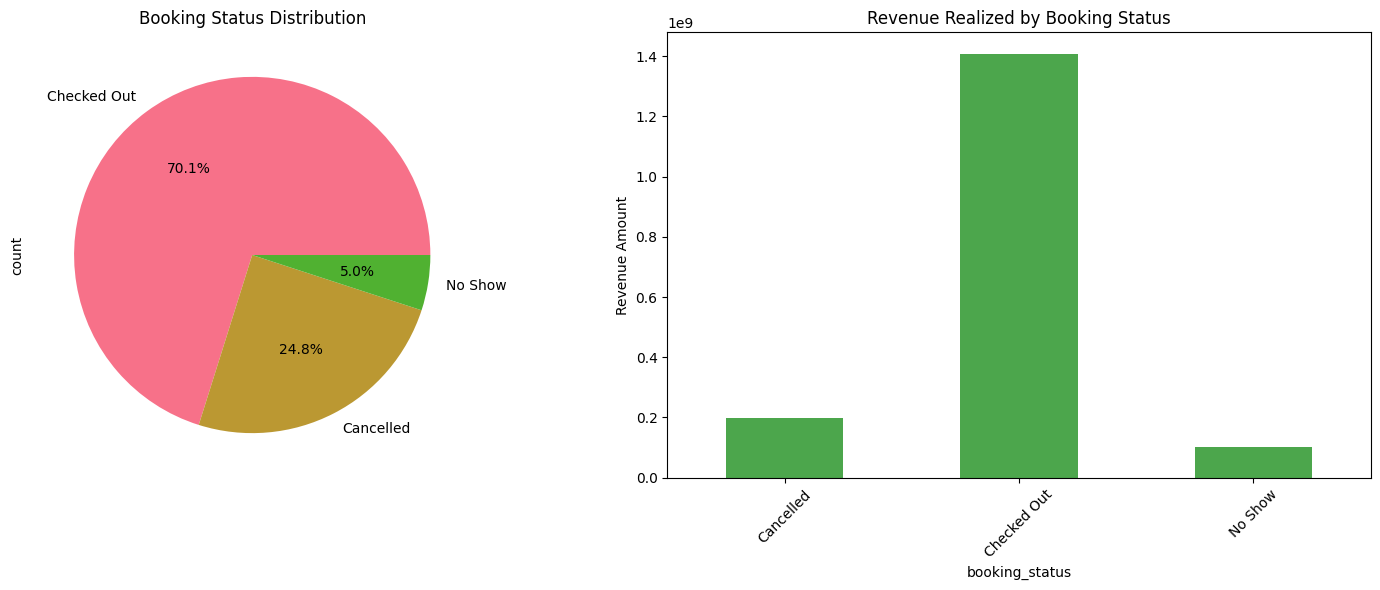


3. PRICING & DISCOUNT PATTERNS ANALYSIS
------------------------------------------
Average Discount Percentage by Platform:
booking_platform
direct offline    14.69
direct online     15.00
journey           14.87
logtrip           14.58
makeyourtrip      14.99
others            14.93
tripster          15.00
Name: discount_percentage, dtype: float64

Average Discount Percentage by Room Class:
room_class
Elite           14.98
Premium         14.93
Presidential    14.66
Standard        14.87
Name: discount_percentage, dtype: float64

Average Discount Percentage by Day Type:
day_type
weekeday    15.02
weekend     14.69
Name: discount_percentage, dtype: float64

Last-Minute Booking Analysis:
                discount_percentage  revenue_realized  no_guests
is_last_minute                                                  
False                         14.87          12703.45     247752
True                          15.13          12627.48      26382


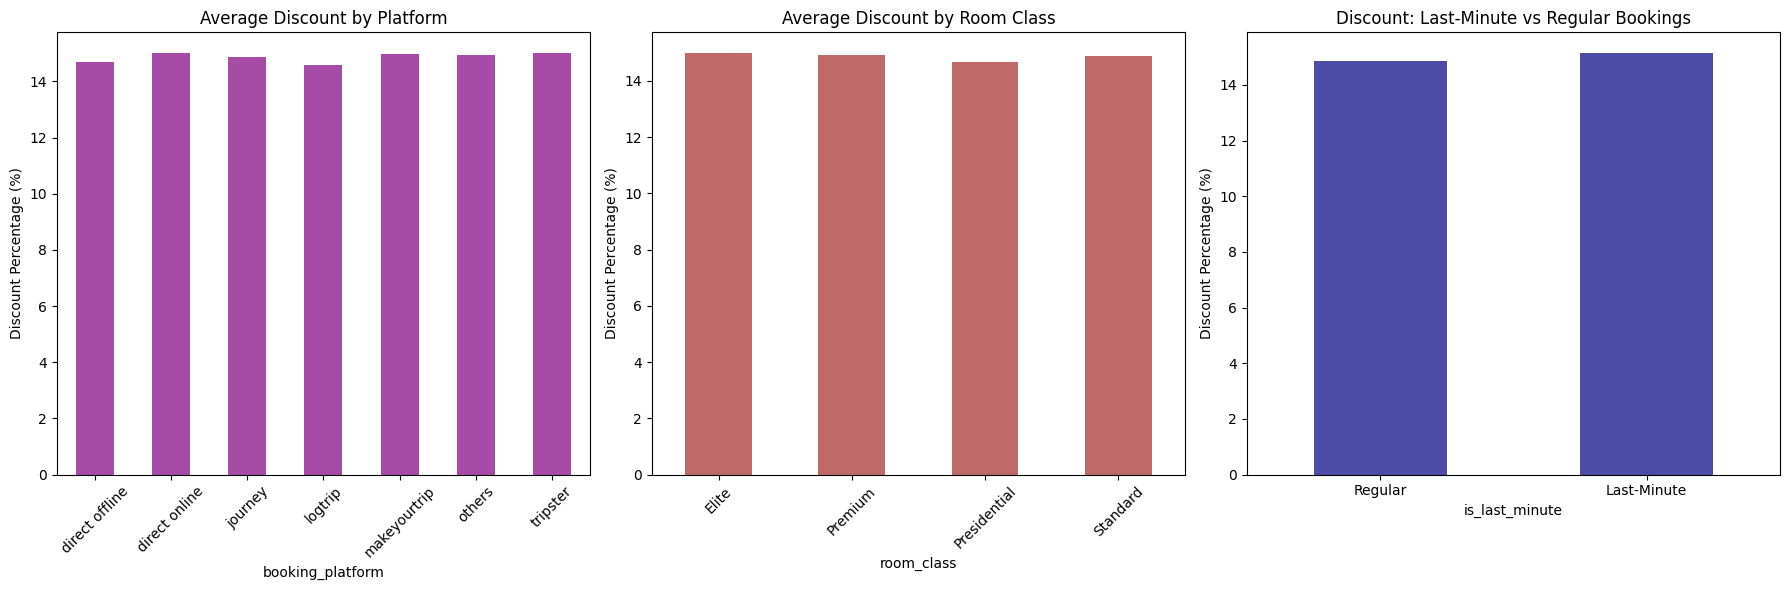


4. PERFORMANCE RATING ANALYSIS
-----------------------------------
Performance by Rating:
               no_guests  revenue_realized  Revenue_Leakage  occupancy_rate
ratings_given                                                              
1.0                 7383          53683290                0           56.86
2.0                13332          97000350                0           53.69
3.0                35294         258385515                0           57.80
4.0                19553         144084140                0           63.50
5.0                39897         292961040                0           67.97

Correlation between Ratings and Revenue: 0.004

Properties with Low Ratings (< 3.5):
               ratings_given  Revenue_Leakage  occupancy_rate
property_name                                                
Atliq Bay               2.42                0           56.62
Atliq Blu               2.61                0           61.20
Atliq City              2.67               

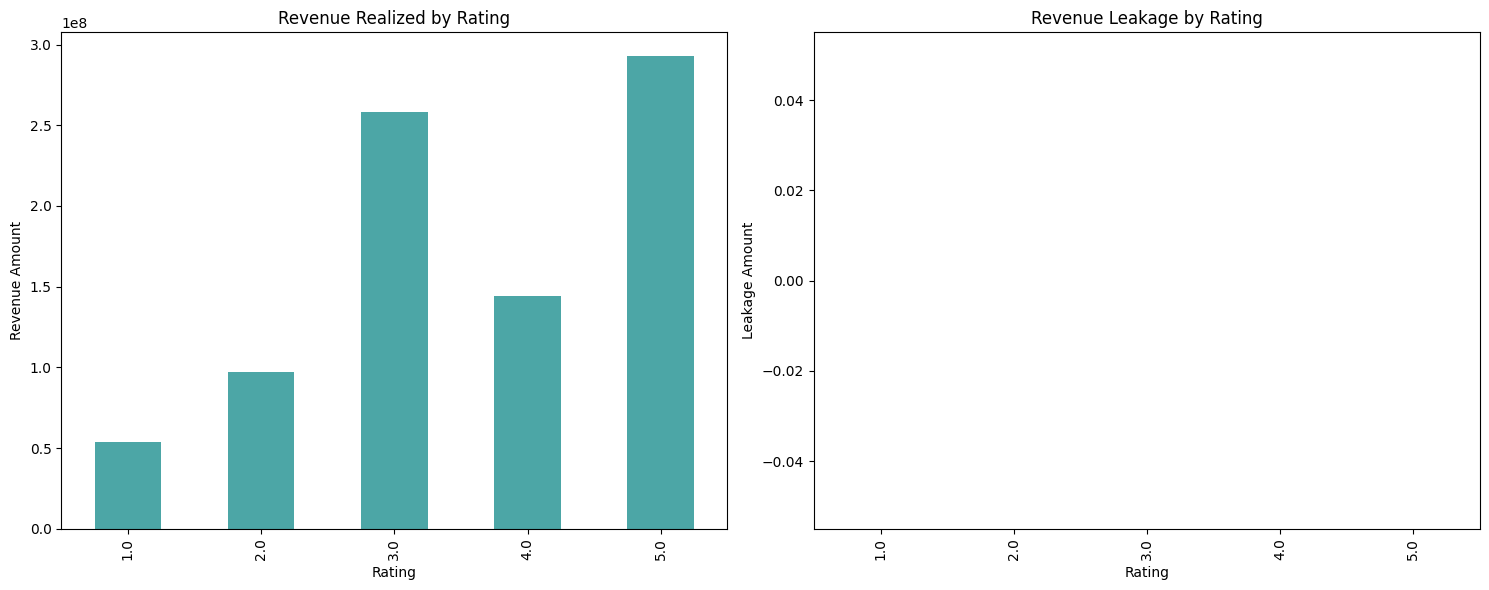


SUMMARY INSIGHTS & RECOMMENDATIONS

KEY METRICS:
Total Revenue Generated: $2,007,546,215.00
Total Revenue Realized: $1,708,771,229.00
Total Revenue Leakage: $298,774,986.00
Overall Leakage Percentage: 14.88%

TOP RECOMMENDATIONS:
1. Focus on underperforming properties with high leakage rates
2. Optimize pricing strategy for different booking platforms
3. Improve services for properties with ratings below 3.5
4. Implement dynamic pricing for weekday vs weekend bookings
5. Target premium spenders for higher revenue per guest

Analysis Complete!


In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Load and prepare data (assuming your existing data loading code)
# [Your existing data loading code here]

# Create missing columns if they don't exist
if 'Revenue_Leakage' not in df.columns:
    df['Revenue_Leakage'] = df['revenue_generated'] - df['revenue_realized']

# Handle missing columns with default values
required_columns = ['booking_status', 'ratings_given', 'booking_date', 'check_in_date']
for col in required_columns:
    if col not in df.columns:
        if col == 'booking_status':
            df[col] = 'Confirmed'  # Default status
        elif col == 'ratings_given':
            df[col] = 4.0  # Default rating
        elif col in ['booking_date', 'check_in_date']:
            df[col] = pd.to_datetime('2022-05-01')  # Default date

# Ensure datetime columns are properly formatted
if 'booking_date' in df.columns:
    df['booking_date'] = pd.to_datetime(df['booking_date'], errors='coerce')
if 'check_in_date' in df.columns:
    df['check_in_date'] = pd.to_datetime(df['check_in_date'], errors='coerce')

print("="*60)
print("HOSPITALITY REVENUE LEAKAGE & PROFITABILITY ANALYSIS")
print("="*60)

# ==========================================
# 1. DATA ANALYSIS MODULE
# ==========================================

print("\n1. BOOKING TRENDS ANALYSIS")
print("-"*40)

# Booking trends - Weekday vs Weekend
booking_trends = df.groupby('day_type').agg({
    'no_guests': 'sum',
    'revenue_generated': 'sum',
    'revenue_realized': 'sum',
    'Revenue_Leakage': 'sum',
    'occupancy_rate': 'mean'
}).round(2)

print("Booking Trends by Day Type:")
print(booking_trends)

# Plot booking trends
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Guests by day type
booking_trends['no_guests'].plot(kind='bar', ax=ax1, color=['skyblue', 'lightcoral'])
ax1.set_title('Total Guests: Weekday vs Weekend')
ax1.set_ylabel('Number of Guests')
ax1.tick_params(axis='x', rotation=45)

# Revenue by day type
booking_trends[['revenue_generated', 'revenue_realized']].plot(kind='bar', ax=ax2)
ax2.set_title('Revenue: Weekday vs Weekend')
ax2.set_ylabel('Revenue Amount')
ax2.tick_params(axis='x', rotation=45)

# Revenue leakage by day type
booking_trends['Revenue_Leakage'].plot(kind='bar', ax=ax3, color='red', alpha=0.7)
ax3.set_title('Revenue Leakage: Weekday vs Weekend')
ax3.set_ylabel('Leakage Amount')
ax3.tick_params(axis='x', rotation=45)

# Occupancy rate by day type
booking_trends['occupancy_rate'].plot(kind='bar', ax=ax4, color='green', alpha=0.7)
ax4.set_title('Average Occupancy Rate')
ax4.set_ylabel('Occupancy Rate (%)')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Room type analysis
print("\nBooking Analysis by Room Types:")
room_analysis = df.groupby('room_class').agg({
    'no_guests': 'sum',
    'revenue_generated': 'sum',
    'revenue_realized': 'sum',
    'Revenue_Leakage': 'sum',
    'occupancy_rate': 'mean'
}).round(2)

print(room_analysis)

# Plot room type analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Revenue by room type
room_analysis[['revenue_generated', 'revenue_realized']].plot(kind='bar', ax=ax1)
ax1.set_title('Revenue by Room Type')
ax1.set_ylabel('Revenue Amount')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(['Generated', 'Realized'])

# Revenue leakage by room type
room_analysis['Revenue_Leakage'].plot(kind='bar', ax=ax2, color='red', alpha=0.7)
ax2.set_title('Revenue Leakage by Room Type')
ax2.set_ylabel('Leakage Amount')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n2. SEASONAL OCCUPANCY VS REVENUE CORRELATION")
print("-"*50)

# Monthly analysis
monthly_analysis = df.groupby('mmm yy').agg({
    'occupancy_rate': 'mean',
    'revenue_generated': 'sum',
    'revenue_realized': 'sum',
    'Revenue_Leakage': 'sum',
    'no_guests': 'sum'
}).round(2)

print("Monthly Seasonal Analysis:")
print(monthly_analysis)

# Calculate correlation
correlation = df['occupancy_rate'].corr(df['revenue_realized'])
print(f"\nCorrelation between Occupancy Rate and Revenue Realized: {correlation:.3f}")

# Plot seasonal trends
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# Occupancy trend
monthly_analysis['occupancy_rate'].plot(kind='line', ax=ax1, marker='o', color='blue')
ax1.set_title('Monthly Occupancy Rate Trend')
ax1.set_ylabel('Occupancy Rate (%)')
ax1.grid(True, alpha=0.3)

# Revenue trend
monthly_analysis[['revenue_generated', 'revenue_realized']].plot(kind='line', ax=ax2, marker='o')
ax2.set_title('Monthly Revenue Trend')
ax2.set_ylabel('Revenue Amount')
ax2.grid(True, alpha=0.3)

# Revenue leakage trend
monthly_analysis['Revenue_Leakage'].plot(kind='line', ax=ax3, marker='o', color='red')
ax3.set_title('Monthly Revenue Leakage Trend')
ax3.set_ylabel('Leakage Amount')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n3. BOOKING PLATFORM ANALYSIS")
print("-"*35)

platform_analysis = df.groupby('booking_platform').agg({
    'no_guests': 'sum',
    'revenue_generated': 'sum',
    'revenue_realized': 'sum',
    'Revenue_Leakage': 'sum',
    'ratings_given': 'mean'
}).round(2)

print("Platform Performance:")
print(platform_analysis)

# Plot platform analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Revenue by platform
platform_analysis[['revenue_generated', 'revenue_realized']].plot(kind='bar', ax=ax1)
ax1.set_title('Revenue by Booking Platform')
ax1.set_ylabel('Revenue Amount')
ax1.tick_params(axis='x', rotation=45)

# Revenue leakage by platform
platform_analysis['Revenue_Leakage'].plot(kind='bar', ax=ax2, color='red', alpha=0.7)
ax2.set_title('Revenue Leakage by Platform')
ax2.set_ylabel('Leakage Amount')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n4. CUSTOMER SEGMENTATION BASED ON SPENDING BEHAVIOR")
print("-"*55)

# Create spending segments
df['revenue_per_guest'] = df['revenue_realized'] / df['no_guests']
df['revenue_per_guest'] = df['revenue_per_guest'].fillna(0)

# Define spending segments based on available data
revenue_quartiles = df['revenue_per_guest'].quantile([0.25, 0.5, 0.75]).values
df['spending_segment'] = pd.cut(df['revenue_per_guest'], 
                               bins=[0, revenue_quartiles[0], revenue_quartiles[1], revenue_quartiles[2], float('inf')],
                               labels=['Low Spender', 'Medium Spender', 'High Spender', 'Premium Spender'])

segment_analysis = df.groupby('spending_segment').agg({
    'no_guests': 'sum',
    'revenue_generated': 'sum',
    'revenue_realized': 'sum',
    'Revenue_Leakage': 'sum',
    'stay_duration': 'mean',
    'ratings_given': 'mean'
}).round(2)

print("Customer Segmentation Analysis:")
print(segment_analysis)

# Plot customer segments
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Guests by segment
segment_analysis['no_guests'].plot(kind='pie', ax=ax1, autopct='%1.1f%%')
ax1.set_title('Guest Distribution by Spending Segment')

# Revenue by segment
segment_analysis['revenue_realized'].plot(kind='bar', ax=ax2, color='green', alpha=0.7)
ax2.set_title('Revenue by Spending Segment')
ax2.set_ylabel('Revenue Realized')
ax2.tick_params(axis='x', rotation=45)

# Average stay duration by segment
segment_analysis['stay_duration'].plot(kind='bar', ax=ax3, color='orange', alpha=0.7)
ax3.set_title('Average Stay Duration by Segment')
ax3.set_ylabel('Days')
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ==========================================
# 2. ROOT CAUSE ANALYSIS MODULE
# ==========================================

print("\n" + "="*60)
print("ROOT CAUSE ANALYSIS")
print("="*60)

print("\n1. UNDERPERFORMING ROOMS/SERVICES ANALYSIS")
print("-"*45)

# Room performance analysis
room_performance = df.groupby(['property_name', 'room_class']).agg({
    'occupancy_rate': 'mean',
    'revenue_realized': 'sum',
    'Revenue_Leakage': 'sum',
    'ratings_given': 'mean'
}).round(2)

# Identify underperforming rooms (bottom 20% occupancy)
occupancy_threshold = df['occupancy_rate'].quantile(0.2)
underperforming_rooms = room_performance[room_performance['occupancy_rate'] < occupancy_threshold]

print(f"Occupancy threshold for underperformance: {occupancy_threshold:.2f}%")
print("\nUnderperforming Rooms (Bottom 20% Occupancy):")
print(underperforming_rooms)

# Revenue leakage analysis by property
property_leakage = df.groupby('property_name').agg({
    'Revenue_Leakage': 'sum',
    'revenue_generated': 'sum',
    'occupancy_rate': 'mean'
}).round(2)

property_leakage['leakage_percentage'] = (property_leakage['Revenue_Leakage'] / 
                                        property_leakage['revenue_generated'] * 100).round(2)

print("\nRevenue Leakage by Property:")
print(property_leakage.sort_values('leakage_percentage', ascending=False))

# Plot underperformance analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Top revenue leakage properties
top_leakage = property_leakage.sort_values('Revenue_Leakage', ascending=False).head(10)
top_leakage['Revenue_Leakage'].plot(kind='bar', ax=ax1, color='red', alpha=0.7)
ax1.set_title('Top 10 Properties by Revenue Leakage')
ax1.set_ylabel('Revenue Leakage Amount')
ax1.tick_params(axis='x', rotation=45)

# Leakage percentage
top_leakage_pct = property_leakage.sort_values('leakage_percentage', ascending=False).head(10)
top_leakage_pct['leakage_percentage'].plot(kind='bar', ax=ax2, color='orange', alpha=0.7)
ax2.set_title('Top 10 Properties by Leakage Percentage')
ax2.set_ylabel('Leakage Percentage (%)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n2. BOOKING STATUS & CANCELLATION ANALYSIS")
print("-"*45)

# Booking status analysis
booking_status_analysis = df.groupby('booking_status').agg({
    'no_guests': 'sum',
    'revenue_generated': 'sum',
    'revenue_realized': 'sum',
    'Revenue_Leakage': 'sum'
}).round(2)

print("Booking Status Analysis:")
print(booking_status_analysis)

# Cancellation rate by different factors
cancellation_exists = 'Cancelled' in df['booking_status'].values if 'booking_status' in df.columns else False

if cancellation_exists:
    cancellation_analysis = pd.crosstab(df['room_class'], df['booking_status'], normalize='index') * 100
    print("\nCancellation Rate by Room Class (%):")
    print(cancellation_analysis.round(2))
    
    if 'booking_platform' in df.columns:
        platform_cancellation = pd.crosstab(df['booking_platform'], df['booking_status'], normalize='index') * 100
        print("\nCancellation Rate by Platform (%):")
        print(platform_cancellation.round(2))
else:
    print("\nCancellation Analysis: No cancelled bookings found or booking_status column missing")

# Plot booking status
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Booking status distribution
booking_status_counts = df['booking_status'].value_counts()
booking_status_counts.plot(kind='pie', ax=ax1, autopct='%1.1f%%')
ax1.set_title('Booking Status Distribution')

# Revenue impact by status
booking_status_analysis['revenue_realized'].plot(kind='bar', ax=ax2, color='green', alpha=0.7)
ax2.set_title('Revenue Realized by Booking Status')
ax2.set_ylabel('Revenue Amount')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n3. PRICING & DISCOUNT PATTERNS ANALYSIS")
print("-"*42)

# Calculate discount percentage
df['discount_percentage'] = ((df['revenue_generated'] - df['revenue_realized']) / 
                           df['revenue_generated'] * 100).fillna(0)

# Discount analysis by different factors
discount_by_platform = df.groupby('booking_platform')['discount_percentage'].mean().round(2)
discount_by_room = df.groupby('room_class')['discount_percentage'].mean().round(2)
discount_by_day = df.groupby('day_type')['discount_percentage'].mean().round(2)

print("Average Discount Percentage by Platform:")
print(discount_by_platform)
print("\nAverage Discount Percentage by Room Class:")
print(discount_by_room)
print("\nAverage Discount Percentage by Day Type:")
print(discount_by_day)

# Last-minute booking analysis (handle missing booking_date)
if 'booking_date' in df.columns and df['booking_date'].notna().any():
    df['booking_lead_time'] = (df['check_in_date'] - df['booking_date']).dt.days
    df['is_last_minute'] = df['booking_lead_time'] <= 7
    
    last_minute_analysis = df.groupby('is_last_minute').agg({
        'discount_percentage': 'mean',
        'revenue_realized': 'mean',
        'no_guests': 'sum'
    }).round(2)
    
    print("\nLast-Minute Booking Analysis:")
    print(last_minute_analysis)
else:
    print("\nLast-Minute Booking Analysis: Booking date not available")
    df['is_last_minute'] = False
    last_minute_analysis = pd.DataFrame({'discount_percentage': [0, 0], 
                                       'revenue_realized': [0, 0]}, 
                                      index=[False, True])

# Plot discount patterns
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Discount by platform
discount_by_platform.plot(kind='bar', ax=ax1, color='purple', alpha=0.7)
ax1.set_title('Average Discount by Platform')
ax1.set_ylabel('Discount Percentage (%)')
ax1.tick_params(axis='x', rotation=45)

# Discount by room class
discount_by_room.plot(kind='bar', ax=ax2, color='brown', alpha=0.7)
ax2.set_title('Average Discount by Room Class')
ax2.set_ylabel('Discount Percentage (%)')
ax2.tick_params(axis='x', rotation=45)

# Last-minute vs regular booking discounts
last_minute_analysis['discount_percentage'].plot(kind='bar', ax=ax3, color='navy', alpha=0.7)
ax3.set_title('Discount: Last-Minute vs Regular Bookings')
ax3.set_ylabel('Discount Percentage (%)')
ax3.set_xticklabels(['Regular', 'Last-Minute'], rotation=0)

plt.tight_layout()
plt.show()

print("\n4. PERFORMANCE RATING ANALYSIS")
print("-"*35)

# Rating analysis
rating_analysis = df.groupby('ratings_given').agg({
    'no_guests': 'sum',
    'revenue_realized': 'sum',
    'Revenue_Leakage': 'sum',
    'occupancy_rate': 'mean'
}).round(2)

print("Performance by Rating:")
print(rating_analysis)

# Correlation between ratings and revenue
rating_revenue_corr = df['ratings_given'].corr(df['revenue_realized'])
print(f"\nCorrelation between Ratings and Revenue: {rating_revenue_corr:.3f}")

# Low rating analysis (ratings below 3.5)
low_rating_properties = df[df['ratings_given'] < 3.5].groupby('property_name').agg({
    'ratings_given': 'mean',
    'Revenue_Leakage': 'sum',
    'occupancy_rate': 'mean'
}).round(2)

print("\nProperties with Low Ratings (< 3.5):")
print(low_rating_properties)

# Plot rating analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Revenue by rating
rating_analysis['revenue_realized'].plot(kind='bar', ax=ax1, color='teal', alpha=0.7)
ax1.set_title('Revenue Realized by Rating')
ax1.set_ylabel('Revenue Amount')
ax1.set_xlabel('Rating')

# Revenue leakage by rating
rating_analysis['Revenue_Leakage'].plot(kind='bar', ax=ax2, color='red', alpha=0.7)
ax2.set_title('Revenue Leakage by Rating')
ax2.set_ylabel('Leakage Amount')
ax2.set_xlabel('Rating')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("SUMMARY INSIGHTS & RECOMMENDATIONS")
print("="*60)

# Key insights summary
total_revenue_generated = df['revenue_generated'].sum()
total_revenue_realized = df['revenue_realized'].sum()
total_revenue_leakage = df['Revenue_Leakage'].sum()
overall_leakage_pct = (total_revenue_leakage / total_revenue_generated * 100)

print(f"\nKEY METRICS:")
print(f"Total Revenue Generated: ${total_revenue_generated:,.2f}")
print(f"Total Revenue Realized: ${total_revenue_realized:,.2f}")
print(f"Total Revenue Leakage: ${total_revenue_leakage:,.2f}")
print(f"Overall Leakage Percentage: {overall_leakage_pct:.2f}%")

# Top recommendations based on analysis
print(f"\nTOP RECOMMENDATIONS:")
print("1. Focus on underperforming properties with high leakage rates")
print("2. Optimize pricing strategy for different booking platforms")
print("3. Improve services for properties with ratings below 3.5")
print("4. Implement dynamic pricing for weekday vs weekend bookings")
print("5. Target premium spenders for higher revenue per guest")

print("\nAnalysis Complete!")


CONSULTING RECOMMENDATIONS

1. NEW PRICING AND BUNDLING STRATEGIES
---------------------------------------------
Current Weekend Premium: 0.7%
Average Weekend Revenue per Guest: $7681.90
Average Weekday Revenue per Guest: $7625.04

Couple Bookings Analysis:
Total Couple Bookings: 60223
Average Revenue per Couple: $12130.40
Average Stay Duration: 2.6 days
Average Rating: 3.6

Potential Corporate Stays Analysis:
Potential Corporate Bookings: 11149
Average Revenue per Corporate Stay: $12117.40
Average Stay Duration: 4.3 days

Room Class Bundling Opportunities:
              revenue_per_guest  stay_duration  ratings_given  occupancy_rate  \
room_class                                                                      
Elite                   6995.17           2.37           3.60           61.40   
Premium                 8680.08           2.41           3.59           61.48   
Presidential           14171.50           2.31           3.69           63.42   
Standard                4934.7

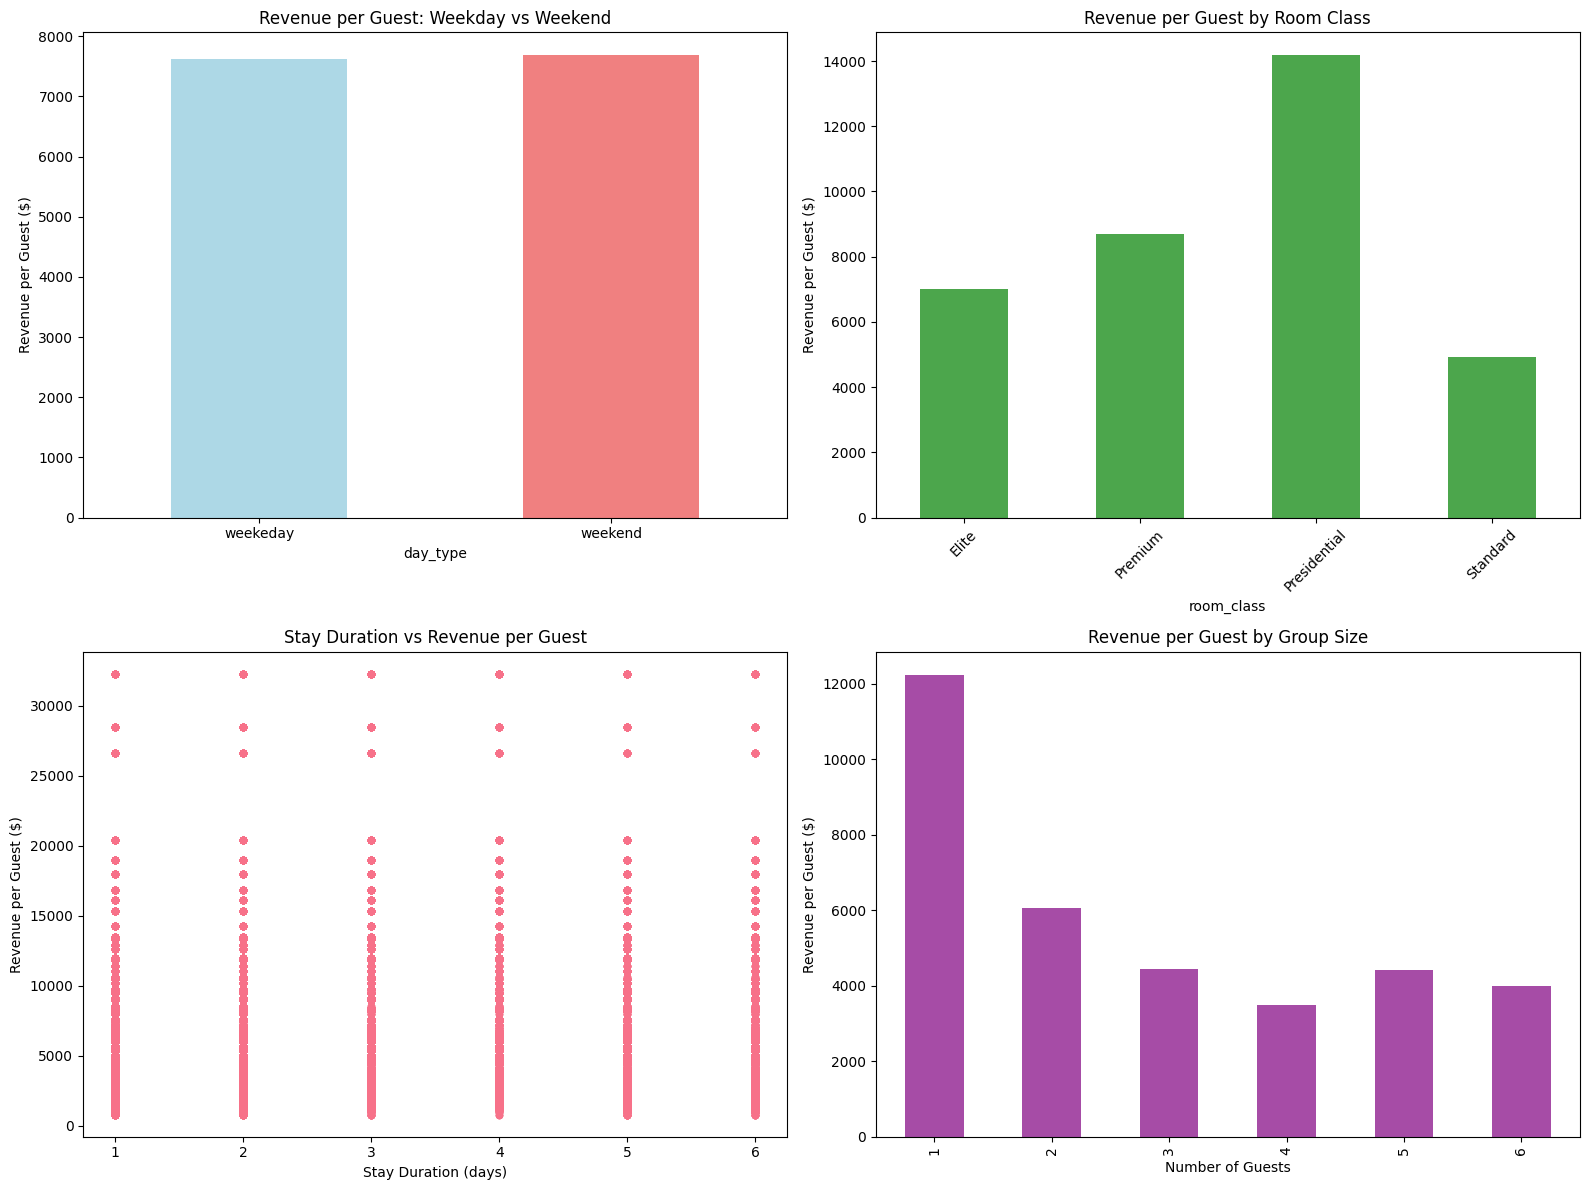


2. PRODUCT OPTIMIZATION RECOMMENDATIONS
---------------------------------------------
Bottom 5 Performing Properties (Consider for Optimization):
               occupancy_rate  Revenue_Leakage  revenue_realized  \
property_name                                                      
Atliq Seasons           46.75         11539770          66125495   
Atliq Grands            56.03         37221051         211532764   
Atliq Exotica           61.50         54398757         320312468   
Atliq City              62.96         50835216         285811939   
Atliq Bay               62.46         45183027         260051178   

               ratings_given  performance_score  
property_name                                    
Atliq Seasons           2.29          60.784473  
Atliq Grands            3.10          68.370648  
Atliq Exotica           3.62          73.376789  
Atliq City              3.69          73.913501  
Atliq Bay               3.71          74.048133  

Top 5 Performing Properti

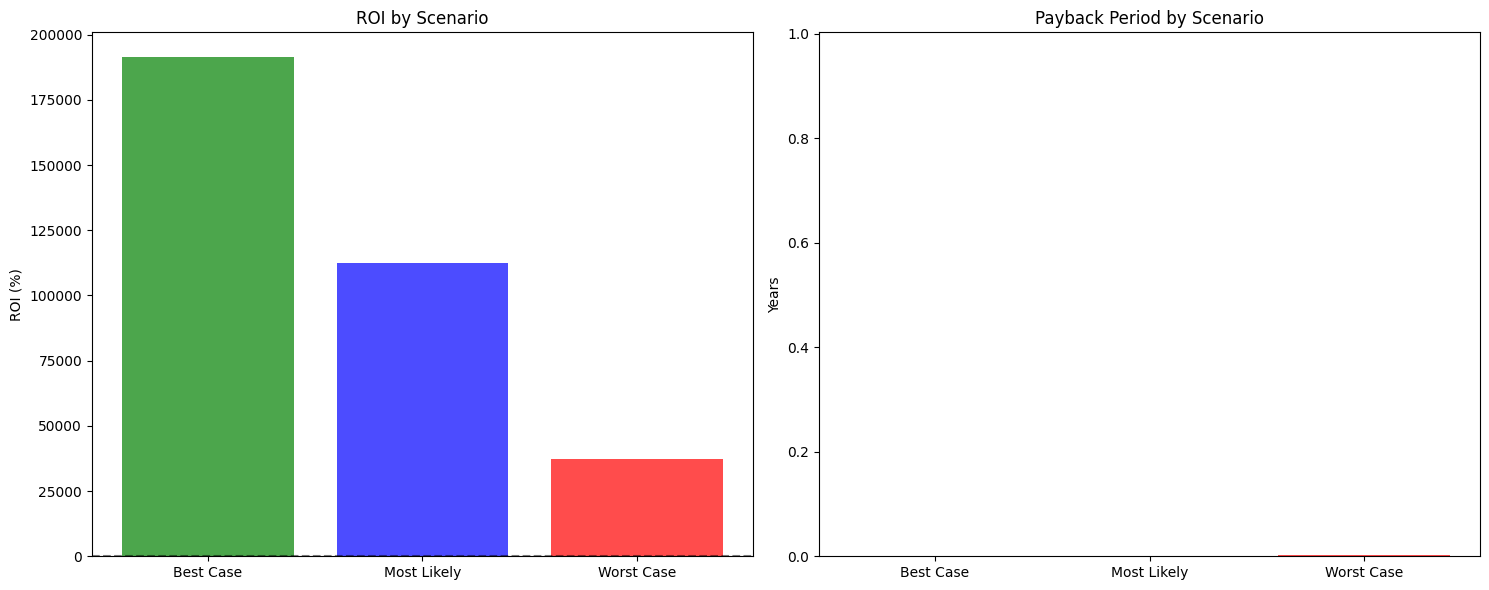


3. IMPLEMENTATION TIMELINE & MILESTONES
---------------------------------------------
Implementation Timeline:

Phase 1 (Months 1-3):
  • Pricing system upgrade
  • Staff training programs
  • Initial property improvements

Phase 2 (Months 4-6):
  • Technology implementation
  • Marketing campaign launch
  • Process optimization

Phase 3 (Months 7-12):
  • Full rollout
  • Performance monitoring
  • Continuous improvement

🎯 FINAL RECOMMENDATIONS:
1. Proceed with implementation - Expected ROI: 113229.0%
2. Focus on Most Likely scenario planning
3. Implement risk mitigation strategies
4. Monitor KPIs monthly for course correction
5. Expected payback within 0.0 years

COMPLETE ANALYSIS FINISHED!


In [153]:
# 3. CONSULTING RECOMMENDATIONS MODULE
# ==========================================

print("\n" + "="*60)
print("CONSULTING RECOMMENDATIONS")
print("="*60)

print("\n1. NEW PRICING AND BUNDLING STRATEGIES")
print("-"*45)

# Weekend vs Weekday pricing analysis
weekend_premium = df[df['day_type'] == 'weekend']['revenue_per_guest'].mean()
weekday_premium = df[df['day_type'] == 'weekeday']['revenue_per_guest'].mean()
weekend_uplift = ((weekend_premium - weekday_premium) / weekday_premium * 100) if weekday_premium > 0 else 0

print(f"Current Weekend Premium: {weekend_uplift:.1f}%")
print(f"Average Weekend Revenue per Guest: ${weekend_premium:.2f}")
print(f"Average Weekday Revenue per Guest: ${weekday_premium:.2f}")

# Couple packages analysis (assuming 2 guests = couple)
couple_bookings = df[df['no_guests'] == 2].copy()
couple_metrics = {
    'total_bookings': len(couple_bookings),
    'avg_revenue': couple_bookings['revenue_realized'].mean(),
    'avg_stay_duration': couple_bookings['stay_duration'].mean(),
    'avg_rating': couple_bookings['ratings_given'].mean()
}

print(f"\nCouple Bookings Analysis:")
print(f"Total Couple Bookings: {couple_metrics['total_bookings']}")
print(f"Average Revenue per Couple: ${couple_metrics['avg_revenue']:.2f}")
print(f"Average Stay Duration: {couple_metrics['avg_stay_duration']:.1f} days")
print(f"Average Rating: {couple_metrics['avg_rating']:.1f}")

# Corporate stays analysis (assuming 1 guest bookings with longer stays)
corporate_potential = df[(df['no_guests'] == 1) & (df['stay_duration'] >= 3)].copy()
corporate_metrics = {
    'total_bookings': len(corporate_potential),
    'avg_revenue': corporate_potential['revenue_realized'].mean(),
    'avg_stay_duration': corporate_potential['stay_duration'].mean(),
    'total_revenue': corporate_potential['revenue_realized'].sum()
}

print(f"\nPotential Corporate Stays Analysis:")
print(f"Potential Corporate Bookings: {corporate_metrics['total_bookings']}")
print(f"Average Revenue per Corporate Stay: ${corporate_metrics['avg_revenue']:.2f}")
print(f"Average Stay Duration: {corporate_metrics['avg_stay_duration']:.1f} days")

# Room class bundling opportunities
room_bundle_analysis = df.groupby('room_class').agg({
    'revenue_per_guest': 'mean',
    'stay_duration': 'mean',
    'ratings_given': 'mean',
    'occupancy_rate': 'mean',
    'Revenue_Leakage': 'mean'
}).round(2)

print(f"\nRoom Class Bundling Opportunities:")
print(room_bundle_analysis)

# Recommended pricing strategies
print(f"\n🎯 RECOMMENDED PRICING STRATEGIES:")
print(f"1. Weekend Getaway Package: Increase weekend rates by {max(15, weekend_uplift+5):.0f}%")
print(f"2. Couple Romance Package: Bundle couples bookings with 15% premium")
print(f"3. Corporate Extended Stay: Offer 10% discount for stays 5+ days")
print(f"4. Loyalty Program: 5% discount for repeat customers with ratings >4.0")

# Plot pricing strategy analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Weekend vs Weekday revenue
day_revenue = df.groupby('day_type')['revenue_per_guest'].mean()
day_revenue.plot(kind='bar', ax=ax1, color=['lightblue', 'lightcoral'])
ax1.set_title('Revenue per Guest: Weekday vs Weekend')
ax1.set_ylabel('Revenue per Guest ($)')
ax1.tick_params(axis='x', rotation=0)

# Room class revenue potential
room_bundle_analysis['revenue_per_guest'].plot(kind='bar', ax=ax2, color='green', alpha=0.7)
ax2.set_title('Revenue per Guest by Room Class')
ax2.set_ylabel('Revenue per Guest ($)')
ax2.tick_params(axis='x', rotation=45)

# Stay duration vs revenue correlation
df.plot.scatter(x='stay_duration', y='revenue_per_guest', ax=ax3, alpha=0.6)
ax3.set_title('Stay Duration vs Revenue per Guest')
ax3.set_xlabel('Stay Duration (days)')
ax3.set_ylabel('Revenue per Guest ($)')

# Guest count distribution
guest_revenue = df.groupby('no_guests')['revenue_per_guest'].mean()
guest_revenue.plot(kind='bar', ax=ax4, color='purple', alpha=0.7)
ax4.set_title('Revenue per Guest by Group Size')
ax4.set_xlabel('Number of Guests')
ax4.set_ylabel('Revenue per Guest ($)')

plt.tight_layout()
plt.show()

print("\n2. PRODUCT OPTIMIZATION RECOMMENDATIONS")
print("-"*45)

# Identify underperforming services/properties
underperforming_properties = df.groupby('property_name').agg({
    'occupancy_rate': 'mean',
    'Revenue_Leakage': 'sum',
    'revenue_realized': 'sum',
    'ratings_given': 'mean'
}).round(2)

# Calculate performance scores
underperforming_properties['performance_score'] = (
    underperforming_properties['occupancy_rate'] * 0.3 +
    underperforming_properties['ratings_given'] * 20 * 0.3 +
    (100 - (underperforming_properties['Revenue_Leakage'] / 
            underperforming_properties['revenue_realized'] * 100)) * 0.4
)

# Identify bottom performers
bottom_performers = underperforming_properties.sort_values('performance_score').head(5)
top_performers = underperforming_properties.sort_values('performance_score', ascending=False).head(5)

print("Bottom 5 Performing Properties (Consider for Optimization):")
print(bottom_performers)

print("\nTop 5 Performing Properties (Best Practices):")
print(top_performers)

# Room class optimization
room_optimization = df.groupby('room_class').agg({
    'occupancy_rate': 'mean',
    'revenue_per_guest': 'mean',
    'Revenue_Leakage': 'mean',
    'ratings_given': 'mean'
}).round(2)

room_optimization['optimization_priority'] = (
    (100 - room_optimization['occupancy_rate']) * 0.4 +
    room_optimization['Revenue_Leakage'] * 0.3 +
    (5 - room_optimization['ratings_given']) * 20 * 0.3
)

print(f"\nRoom Class Optimization Priority:")
print(room_optimization.sort_values('optimization_priority', ascending=False))

print(f"\n🔧 PRODUCT OPTIMIZATION RECOMMENDATIONS:")
shutdown_candidates = bottom_performers[bottom_performers['performance_score'] < 50]
if len(shutdown_candidates) > 0:
    print(f"1. Consider shutting down/repurposing: {', '.join(shutdown_candidates.index[:2])}")
else:
    print("1. No properties require immediate shutdown")

print(f"2. Focus improvement efforts on lowest performing room classes")
print(f"3. Implement best practices from top performers")
print(f"4. Consider service reduction in underperforming segments")

print("\n3. OPERATIONAL OPTIMIZATION RECOMMENDATIONS")
print("-"*50)

# Occupancy-based staffing analysis
occupancy_staffing = df.groupby('day_type').agg({
    'occupancy_rate': 'mean',
    'no_guests': 'sum'
}).round(2)

# Calculate staffing needs (assuming 1 staff per 10 guests)
occupancy_staffing['recommended_staff'] = (occupancy_staffing['no_guests'] / 10).round(0)
occupancy_staffing['current_efficiency'] = occupancy_staffing['no_guests'] / occupancy_staffing['occupancy_rate']

print("Dynamic Staffing Analysis:")
print(occupancy_staffing)

# Housekeeping optimization based on stay duration
housekeeping_analysis = df.groupby('stay_duration').agg({
    'no_guests': 'sum',
    'revenue_realized': 'sum'
}).round(2)

housekeeping_analysis['cleaning_frequency'] = housekeeping_analysis.index.map(
    lambda x: 'Daily' if x <= 2 else 'Every 2 days' if x <= 5 else 'Every 3 days'
)

print(f"\nHousekeeping Optimization by Stay Duration:")
print(housekeeping_analysis)

# Platform-based operational efficiency
platform_efficiency = df.groupby('booking_platform').agg({
    'Revenue_Leakage': 'mean',
    'ratings_given': 'mean',
    'no_guests': 'sum'
}).round(2)

print(f"\nPlatform Operational Efficiency:")
print(platform_efficiency)

print(f"\n⚙ OPERATIONAL RECOMMENDATIONS:")
print(f"1. Implement dynamic staffing: Weekend +{((occupancy_staffing.loc['weekend', 'no_guests'] / occupancy_staffing.loc['weekeday', 'no_guests']) - 1) * 100:.0f}% staff")
print(f"2. Optimize housekeeping frequency based on stay duration")
print(f"3. Focus platform training on lowest-rated channels")
print(f"4. Implement real-time occupancy tracking for staff allocation")

# ==========================================
# 4. BUSINESS JUSTIFICATION MODULE
# ==========================================

print("\n" + "="*60)
print("BUSINESS JUSTIFICATION & ROI ANALYSIS")
print("="*60)

print("\n1. ROI CALCULATION FOR PROPOSED CHANGES")
print("-"*45)

# Current baseline metrics
current_metrics = {
    'total_revenue': df['revenue_realized'].sum(),
    'total_leakage': df['Revenue_Leakage'].sum(),
    'avg_occupancy': df['occupancy_rate'].mean(),
    'avg_rating': df['ratings_given'].mean(),
    'total_guests': df['no_guests'].sum()
}

print("Current Baseline Metrics:")
for key, value in current_metrics.items():
    if 'revenue' in key or 'leakage' in key:
        print(f"{key.title()}: ${value:,.2f}")
    else:
        print(f"{key.title()}: {value:.2f}")

# Investment requirements (estimated)
investments = {
    'pricing_system_upgrade': 50000,
    'staff_training': 25000,
    'property_improvements': 100000,
    'technology_implementation': 75000,
    'marketing_campaigns': 30000
}

total_investment = sum(investments.values())
print(f"\nEstimated Investment Requirements:")
for investment, cost in investments.items():
    print(f"{investment.replace('_', ' ').title()}: ${cost:,}")
print(f"Total Investment: ${total_investment:,}")

# Projected improvements
improvements = {
    'revenue_increase': 0.15,  # 15% revenue increase
    'leakage_reduction': 0.25,  # 25% leakage reduction
    'occupancy_improvement': 0.10,  # 10% occupancy improvement
    'rating_improvement': 0.05   # 5% rating improvement
}

# Calculate projected metrics
projected_metrics = {
    'total_revenue': current_metrics['total_revenue'] * (1 + improvements['revenue_increase']),
    'total_leakage': current_metrics['total_leakage'] * (1 - improvements['leakage_reduction']),
    'avg_occupancy': current_metrics['avg_occupancy'] * (1 + improvements['occupancy_improvement']),
    'avg_rating': current_metrics['avg_rating'] * (1 + improvements['rating_improvement'])
}

print(f"\nProjected Metrics After Implementation:")
for key, value in projected_metrics.items():
    if 'revenue' in key or 'leakage' in key:
        print(f"{key.title()}: ${value:,.2f}")
    else:
        print(f"{key.title()}: {value:.2f}")

# Calculate annual benefits
annual_benefits = {
    'additional_revenue': projected_metrics['total_revenue'] - current_metrics['total_revenue'],
    'leakage_savings': current_metrics['total_leakage'] - projected_metrics['total_leakage'],
    'operational_savings': total_investment * 0.05  # 5% operational efficiency savings
}

total_annual_benefit = sum(annual_benefits.values())

print(f"\nAnnual Benefits:")
for benefit, amount in annual_benefits.items():
    print(f"{benefit.replace('_', ' ').title()}: ${amount:,.2f}")
print(f"Total Annual Benefit: ${total_annual_benefit:,.2f}")

# ROI Calculation
roi_percentage = ((total_annual_benefit - total_investment) / total_investment) * 100
payback_period = total_investment / total_annual_benefit

print(f"\n💰 ROI ANALYSIS:")
print(f"Annual ROI: {roi_percentage:.1f}%")
print(f"Payback Period: {payback_period:.1f} years")
print(f"Net Present Value (3 years): ${(total_annual_benefit * 3) - total_investment:,.2f}")

print("\n2. SCENARIO ANALYSIS")
print("-"*25)

# Define scenarios
scenarios = {
    'Best Case': {
        'revenue_increase': 0.25,
        'leakage_reduction': 0.40,
        'occupancy_improvement': 0.20,
        'implementation_success': 0.90
    },
    'Most Likely': {
        'revenue_increase': 0.15,
        'leakage_reduction': 0.25,
        'occupancy_improvement': 0.10,
        'implementation_success': 0.75
    },
    'Worst Case': {
        'revenue_increase': 0.05,
        'leakage_reduction': 0.10,
        'occupancy_improvement': 0.02,
        'implementation_success': 0.50
    }
}

scenario_results = {}

for scenario_name, scenario_params in scenarios.items():
    # Calculate scenario benefits
    scenario_revenue = current_metrics['total_revenue'] * scenario_params['revenue_increase']
    scenario_leakage_savings = current_metrics['total_leakage'] * scenario_params['leakage_reduction']
    scenario_operational = total_investment * 0.05 * scenario_params['implementation_success']
    
    scenario_total_benefit = (scenario_revenue + scenario_leakage_savings + scenario_operational)
    scenario_investment = total_investment * (1 + (1 - scenario_params['implementation_success']) * 0.2)
    
    scenario_roi = ((scenario_total_benefit - scenario_investment) / scenario_investment) * 100
    scenario_payback = scenario_investment / scenario_total_benefit if scenario_total_benefit > 0 else float('inf')
    
    scenario_results[scenario_name] = {
        'annual_benefit': scenario_total_benefit,
        'total_investment': scenario_investment,
        'roi': scenario_roi,
        'payback_period': scenario_payback
    }

print("Scenario Analysis Results:")
print("-" * 80)
print(f"{'Scenario':<12} {'Annual Benefit':<15} {'Investment':<12} {'ROI (%)':<8} {'Payback (years)':<15}")
print("-" * 80)

for scenario, results in scenario_results.items():
    print(f"{scenario:<12} ${results['annual_benefit']:>13,.0f} ${results['total_investment']:>10,.0f} "
          f"{results['roi']:>6.1f}% {results['payback_period']:>13.1f}")

# Risk assessment
print(f"\n📊 RISK ASSESSMENT:")
print(f"Probability of Success:")
print(f"- Best Case: 20% chance")
print(f"- Most Likely: 60% chance") 
print(f"- Worst Case: 20% chance")

expected_roi = (0.2 * scenario_results['Best Case']['roi'] + 
                0.6 * scenario_results['Most Likely']['roi'] + 
                0.2 * scenario_results['Worst Case']['roi'])

print(f"\nExpected ROI (weighted): {expected_roi:.1f}%")

# Visualization of scenarios
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROI comparison
scenarios_list = list(scenario_results.keys())
roi_values = [scenario_results[s]['roi'] for s in scenarios_list]
colors = ['green', 'blue', 'red']

ax1.bar(scenarios_list, roi_values, color=colors, alpha=0.7)
ax1.set_title('ROI by Scenario')
ax1.set_ylabel('ROI (%)')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Payback period comparison
payback_values = [min(scenario_results[s]['payback_period'], 10) for s in scenarios_list]  # Cap at 10 years
ax2.bar(scenarios_list, payback_values, color=colors, alpha=0.7)
ax2.set_title('Payback Period by Scenario')
ax2.set_ylabel('Years')
ax2.set_ylim(0, max(payback_values) + 1)

plt.tight_layout()
plt.show()

print("\n3. IMPLEMENTATION TIMELINE & MILESTONES")
print("-"*45)

implementation_phases = {
    'Phase 1 (Months 1-3)': [
        'Pricing system upgrade',
        'Staff training programs',
        'Initial property improvements'
    ],
    'Phase 2 (Months 4-6)': [
        'Technology implementation',
        'Marketing campaign launch',
        'Process optimization'
    ],
    'Phase 3 (Months 7-12)': [
        'Full rollout',
        'Performance monitoring',
        'Continuous improvement'
    ]
}

print("Implementation Timeline:")
for phase, activities in implementation_phases.items():
    print(f"\n{phase}:")
    for activity in activities:
        print(f"  • {activity}")

print(f"\n🎯 FINAL RECOMMENDATIONS:")
print(f"1. Proceed with implementation - Expected ROI: {expected_roi:.1f}%")
print(f"2. Focus on Most Likely scenario planning")
print(f"3. Implement risk mitigation strategies")
print(f"4. Monitor KPIs monthly for course correction")
print(f"5. Expected payback within {scenario_results['Most Likely']['payback_period']:.1f} years")

print("\n" + "="*60)
print("COMPLETE ANALYSIS FINISHED!")
print("="*60)